# Analyse Energy Prices in Spain & make forecast

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


import datetime
from TSF_Package import TSF
# from darts import TimeSeries, concatenate
# from darts.dataprocessing.transformers import Scaler
# from darts.models import TransformerModel
# from darts.metrics import mape, rmse
# from darts.utils.timeseries_generation import datetime_attribute_timeseries
# from darts.utils.likelihood_models import QuantileRegression


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [22]:
# Load the data
dfe = pd.read_csv("energy_dataset.csv", header=0, parse_dates=["time"])
dfw = pd.read_csv("weather_features.csv", header=0, parse_dates=["dt_iso"])

## Analyse the Energy Dataset

In [23]:
# Check the data
dfe.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.00,329.00,0.00,"4,844.00","4,821.00",162.00,0.00,0.00,0.00,...,196.00,0.00,"6,378.00",17.00,NaN,"6,436.00","26,118.00","25,385.00",50.10,65.41
1,2015-01-01 01:00:00+01:00,449.00,328.00,0.00,"5,196.00","4,755.00",158.00,0.00,0.00,0.00,...,195.00,0.00,"5,890.00",16.00,NaN,"5,856.00","24,934.00","24,382.00",48.10,64.92
2,2015-01-01 02:00:00+01:00,448.00,323.00,0.00,"4,857.00","4,581.00",157.00,0.00,0.00,0.00,...,196.00,0.00,"5,461.00",8.00,NaN,"5,454.00","23,515.00","22,734.00",47.33,64.48
3,2015-01-01 03:00:00+01:00,438.00,254.00,0.00,"4,314.00","4,131.00",160.00,0.00,0.00,0.00,...,191.00,0.00,"5,238.00",2.00,NaN,"5,151.00","22,642.00","21,286.00",42.27,59.32
4,2015-01-01 04:00:00+01:00,428.00,187.00,0.00,"4,130.00","3,840.00",156.00,0.00,0.00,0.00,...,189.00,0.00,"4,935.00",9.00,NaN,"4,861.00","21,785.00","20,264.00",38.41,56.04


In [24]:
dfw.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.48,270.48,270.48,1001,77,1,62,0.00,0.00,0.00,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.48,270.48,270.48,1001,77,1,62,0.00,0.00,0.00,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.69,269.69,269.69,1002,78,0,23,0.00,0.00,0.00,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.69,269.69,269.69,1002,78,0,23,0.00,0.00,0.00,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.69,269.69,269.69,1002,78,0,23,0.00,0.00,0.00,0,800,clear,sky is clear,01n


In [25]:
# Check the data types
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [26]:
# Copy of the original data
df1e = dfe.copy()
df1w = dfw.copy()

In [27]:
# First data cleaning and preparation
df1e["time"] = pd.to_datetime(df1e["time"], utc=True, infer_datetime_format=True)

In [28]:
# Duplikate in der Zeitreihe?
print("Anzahl Duplikate:",df1e.duplicated(subset=["time"], keep="first").sum())

Anzahl Duplikate: 0


In [29]:
# Setze Index
df1e.set_index("time", inplace=True)

In [30]:
# Nicht numerische Datentypen
print("Nicht numerische Datentypen:",list(df1e.dtypes[df1e.dtypes == "object"].index))

Nicht numerische Datentypen: []


### Check for missing values

Missing values: 



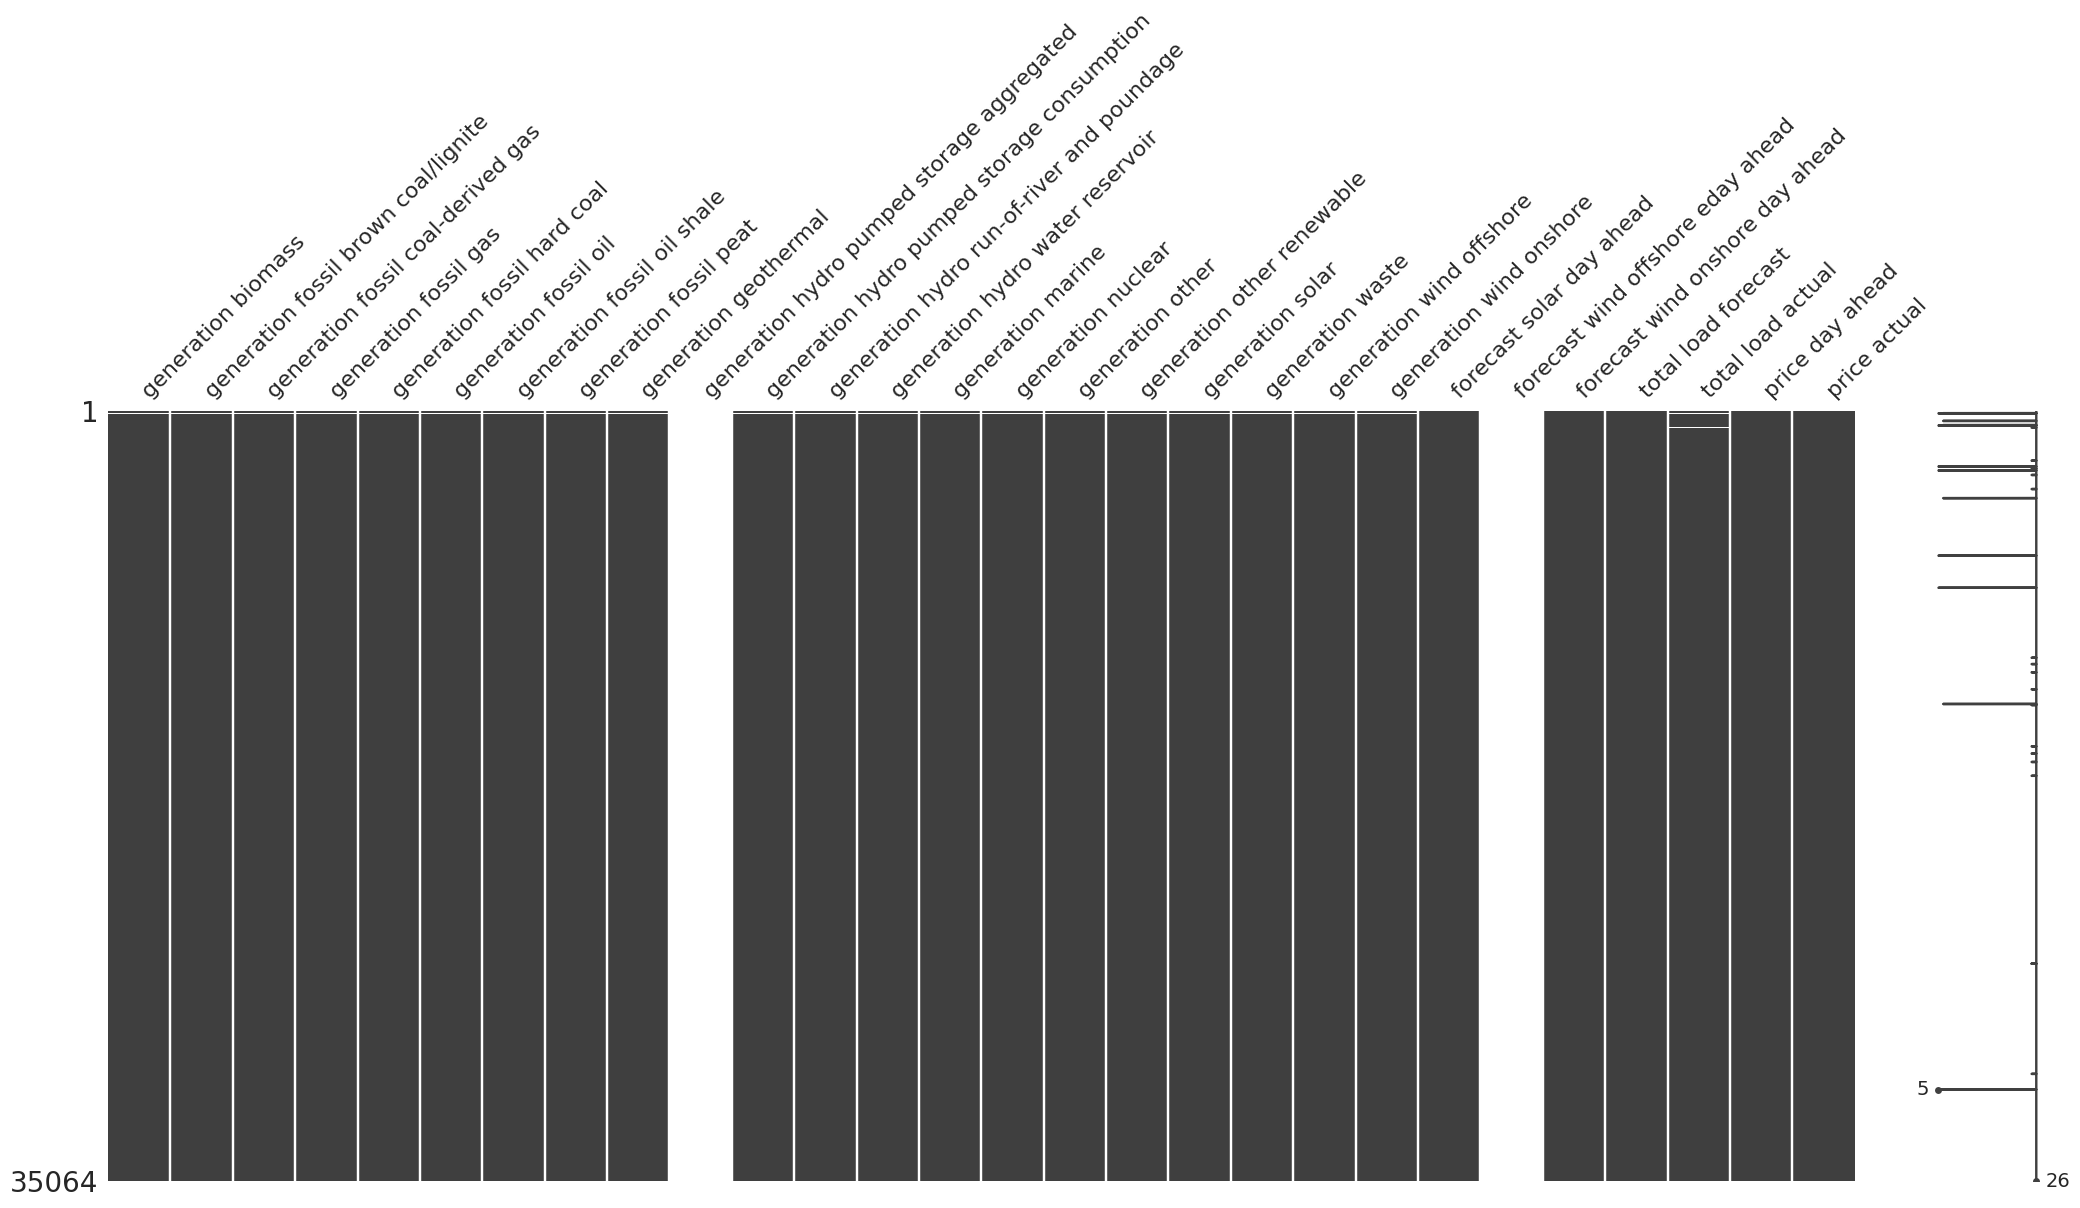

In [31]:
# Check for missing values
def gaps(df):
    if df.isnull().values.any():
        print("Missing values: \n")
        mno.matrix(df)
    else:
        print("No missing values")

gaps(df1e)

In [32]:
# Drop Spalten mit zu vielen fehlenden Werten und forecast Spalten mit Regex
df1e = df1e.drop(df1e.filter(regex="forecast").columns, axis=1, errors="ignore")
df1e.dropna(axis=1, how="all", inplace=True)
df1e = df1e.loc[:, (df1e != 0).any(axis=0)]

# Fülle die fehlenden Werte mit der letzten bekannten Werte (Interpolation)
df1e = df1e.interpolate(method ="bfill")

# Immernoch fehlende Werte?
gaps(df1e)
df1e = df1e.loc[:, (df1e != 0).any(axis=0)]

No missing values


In [33]:
# Rename columns and get rid of whitespaces ans special characters
colnames_old = df1e.columns
colnames_new = ["gen_bio", "gen_lig", "gen_gas", "gen_coal", \
                "gen_oil", "gen_hyd_pump", "gen_hyd_river", "gen_hyd_res", \
                "gen_nuc", "gen_other", "gen_oth_renew", "gen_solar", \
                "gen_waste", "gen_wind", "load_actual", "price_dayahead", \
                "price"]
dict_cols = dict(zip(colnames_old, colnames_new))
df1e.rename(columns=dict_cols, inplace=True)
print(df1e.info())
df1e.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gen_bio         35064 non-null  float64
 1   gen_lig         35064 non-null  float64
 2   gen_gas         35064 non-null  float64
 3   gen_coal        35064 non-null  float64
 4   gen_oil         35064 non-null  float64
 5   gen_hyd_pump    35064 non-null  float64
 6   gen_hyd_river   35064 non-null  float64
 7   gen_hyd_res     35064 non-null  float64
 8   gen_nuc         35064 non-null  float64
 9   gen_other       35064 non-null  float64
 10  gen_oth_renew   35064 non-null  float64
 11  gen_solar       35064 non-null  float64
 12  gen_waste       35064 non-null  float64
 13  gen_wind        35064 non-null  float64
 14  load_actual     35064 non-null  float64
 15  price_dayahead  35064 non-null  float64
 16  price           35064 non-nul

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,gen_oth_renew,gen_solar,gen_waste,gen_wind,load_actual,price_dayahead,price
count,"35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00"
mean,383.53,448.10,"5,622.70","4,256.51",298.34,475.60,972.20,"2,605.57","6,263.47",60.23,85.63,"1,432.83",269.42,"5,464.85","28,698.95",49.87,57.88
std,85.35,354.62,"2,201.48","1,962.01",52.52,792.34,400.71,"1,835.35",840.30,20.24,14.08,"1,679.95",50.22,"3,213.47","4,576.56",14.62,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"18,041.00",2.06,9.33
25%,333.00,0.00,"4,126.00","2,527.00",263.00,0.00,637.00,"1,078.00","5,759.00",53.00,73.00,71.00,240.00,"2,933.00","24,807.75",41.49,49.35
50%,367.00,509.00,"4,969.00","4,475.00",300.00,68.00,906.00,"2,164.00","6,564.00",57.00,88.00,616.00,279.00,"4,849.50","28,904.00",50.52,58.02
75%,433.00,757.00,"6,429.00","5,839.00",330.00,616.00,"1,250.00","3,758.00","7,025.00",80.00,97.00,"2,579.00",310.00,"7,401.00","32,195.00",60.53,68.01
max,592.00,999.00,"20,034.00","8,359.00",449.00,"4,523.00","2,000.00","9,728.00","7,117.00",106.00,119.00,"5,792.00",357.00,"17,436.00","41,015.00",101.99,116.80


In [34]:
colnames_old

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual'],
      dtype='object')

In [35]:
# convert int and float64 columns to float32
intcols = list(df1e.dtypes[df1e.dtypes == np.int64].index)
df1e[intcols] = df1e[intcols].applymap(np.float32)

f64cols = list(df1e.dtypes[df1e.dtypes == np.float64].index)
df1e[f64cols] = df1e[f64cols].applymap(np.float32)

In [36]:
df1e

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,gen_oth_renew,gen_solar,gen_waste,gen_wind,load_actual,price_dayahead,price
time,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.00,329.00,"4,844.00","4,821.00",162.00,863.00,"1,051.00","1,899.00","7,096.00",43.00,73.00,49.00,196.00,"6,378.00","25,385.00",50.10,65.41
2015-01-01 00:00:00+00:00,449.00,328.00,"5,196.00","4,755.00",158.00,920.00,"1,009.00","1,658.00","7,096.00",43.00,71.00,50.00,195.00,"5,890.00","24,382.00",48.10,64.92
2015-01-01 01:00:00+00:00,448.00,323.00,"4,857.00","4,581.00",157.00,"1,164.00",973.00,"1,371.00","7,099.00",43.00,73.00,50.00,196.00,"5,461.00","22,734.00",47.33,64.48
2015-01-01 02:00:00+00:00,438.00,254.00,"4,314.00","4,131.00",160.00,"1,503.00",949.00,779.00,"7,098.00",43.00,75.00,50.00,191.00,"5,238.00","21,286.00",42.27,59.32
2015-01-01 03:00:00+00:00,428.00,187.00,"4,130.00","3,840.00",156.00,"1,826.00",953.00,720.00,"7,097.00",43.00,74.00,42.00,189.00,"4,935.00","20,264.00",38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,297.00,0.00,"7,634.00","2,628.00",178.00,1.00,"1,135.00","4,836.00","6,073.00",63.00,95.00,85.00,277.00,"3,113.00","30,653.00",68.85,77.02
2018-12-31 19:00:00+00:00,296.00,0.00,"7,241.00","2,566.00",174.00,1.00,"1,172.00","3,931.00","6,074.00",62.00,95.00,33.00,280.00,"3,288.00","29,735.00",68.40,76.16
2018-12-31 20:00:00+00:00,292.00,0.00,"7,025.00","2,422.00",168.00,50.00,"1,148.00","2,831.00","6,076.00",61.00,94.00,31.00,286.00,"3,503.00","28,071.00",66.88,74.30


### Plot hourly energy prices over time (x-axis)

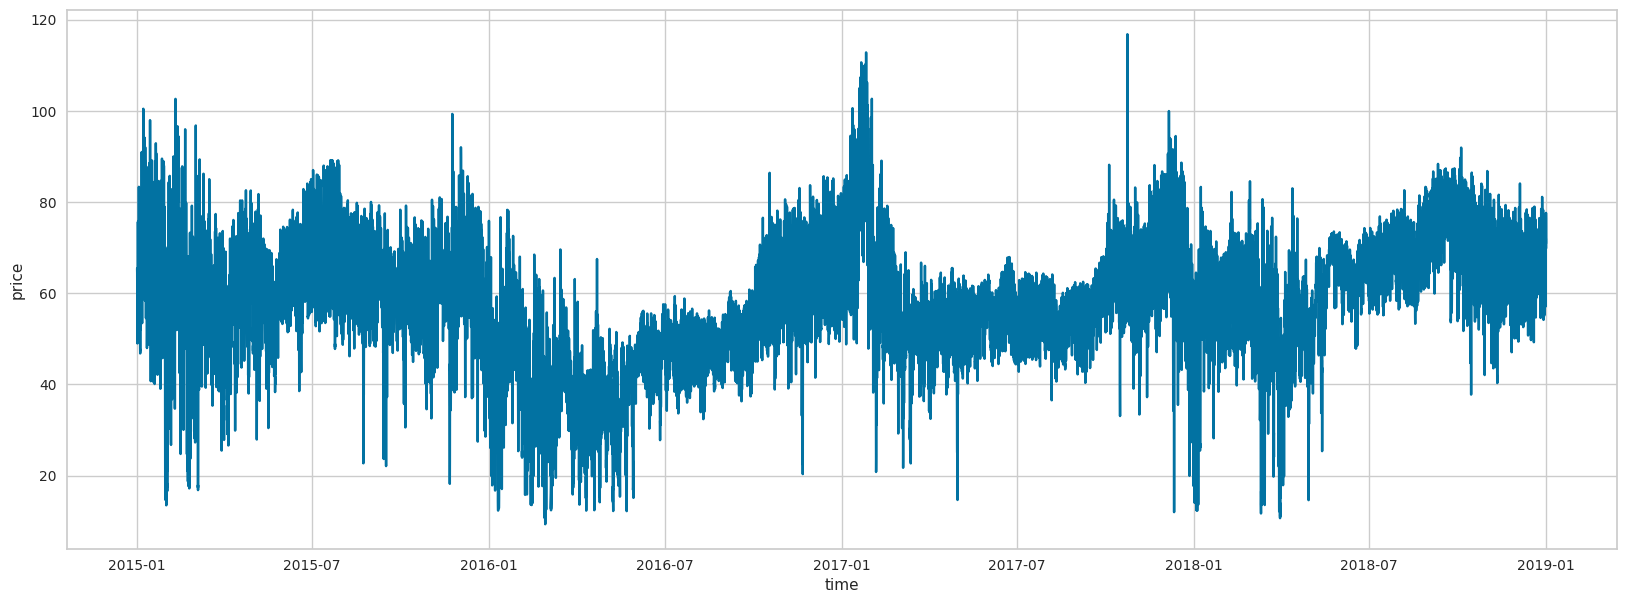

In [37]:
# Plot hourly prices over time
plt.figure(100, figsize=(20, 7))
sns.lineplot(x = "time", y = "price", data = df1e, palette="coolwarm");

### Trend and seasonality

#### Time of day:
 influenced by the different electricity consumption during daytime and business hours; and the generation of solar energy is limited to the daytime

#### Weekdays:
Electricity consumption is higher on weekdays than on weekends

#### Months:
 Seasonal fluctuations in demand caused by temperature differences and seasonal fluctuations in the output of solar and wind power plants


## Analyse the weather dataset

In [38]:
# Prepare weather dataset
df1w["time"] = pd.to_datetime(df1w["dt_iso"], utc=True, infer_datetime_format=True)
df1w.set_index("time", inplace=True)


# any non-numeric types?
print("non-numeric columns:",list(df1w.dtypes[df1w.dtypes == "object"].index))

gaps(df1w) 


df1w.describe()

non-numeric columns: ['dt_iso', 'city_name', 'weather_main', 'weather_description', 'weather_icon']
No missing values


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,"178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00"
mean,289.62,288.33,291.09,"1,069.26",68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,"5,969.63",21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,"1,013.00",53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,"1,018.00",72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,"1,022.00",87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,"1,008,371.00",100.00,133.00,360.00,12.00,2.31,21.50,100.00,804.00


In [39]:
# Drop redundant columns and unnecessary columns
df1w.drop(["rain_3h", "weather_id", "weather_main", "weather_description", "weather_icon"], 
          inplace=True, axis=1, errors="ignore")

# Konvertiere Temp von Kelvin nach Celsius
temp_cols = [col for col in df1w.columns if "temp" in col]
df1w[temp_cols] = df1w[temp_cols].filter(like="temp").applymap(lambda t: t - 273.15)

# Konvertiere int und float64 zu float32
intcols = list(df1w.dtypes[df1w.dtypes == np.int64].index)
df1w[intcols] = df1w[intcols].applymap(np.float32)

f64cols = list(df1w.dtypes[df1w.dtypes == np.float64].index)
df1w[f64cols] = df1w[f64cols].applymap(np.float32)

f32cols = list(df1w.dtypes[df1w.dtypes == np.float32].index)
df1w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178396 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   dt_iso      178396 non-null  object 
 1   city_name   178396 non-null  object 
 2   temp        178396 non-null  float32
 3   temp_min    178396 non-null  float32
 4   temp_max    178396 non-null  float32
 5   pressure    178396 non-null  float32
 6   humidity    178396 non-null  float32
 7   wind_speed  178396 non-null  float32
 8   wind_deg    178396 non-null  float32
 9   rain_1h     178396 non-null  float32
 10  snow_3h     178396 non-null  float32
 11  clouds_all  178396 non-null  float32
dtypes: float32(10), object(2)
memory usage: 10.9+ MB


# Check and evaluate outliers in the dataset

In [40]:
# Check Ausreiser in der Druck Spalte
df1w["pressure"].nlargest(10)

time
2015-02-21 01:00:00+00:00   1,008,371.00
2015-02-22 07:00:00+00:00   1,002,881.00
2015-02-22 06:00:00+00:00   1,002,241.00
2015-02-21 08:00:00+00:00   1,001,781.00
2015-02-21 09:00:00+00:00   1,001,501.00
2015-02-21 10:00:00+00:00   1,000,951.00
2015-02-20 08:00:00+00:00     102,153.00
2015-02-20 09:00:00+00:00     102,132.00
2015-02-20 10:00:00+00:00     102,075.00
2015-02-20 11:00:00+00:00     101,983.00
Name: pressure, dtype: float32

In [41]:
# Check Ausreiser in der Windgeschwindigkeit Spalte
df1w["wind_speed"].nlargest(10)

time
2017-05-11 10:00:00+00:00   133.00
2015-01-30 10:00:00+00:00    64.00
2015-01-30 14:00:00+00:00    54.00
2015-02-23 21:00:00+00:00    43.00
2015-01-30 15:00:00+00:00    40.00
2015-01-30 18:00:00+00:00    38.00
2015-01-30 02:00:00+00:00    35.00
2015-01-30 09:00:00+00:00    33.00
2015-01-16 12:00:00+00:00    30.00
2015-01-29 13:00:00+00:00    30.00
Name: wind_speed, dtype: float32

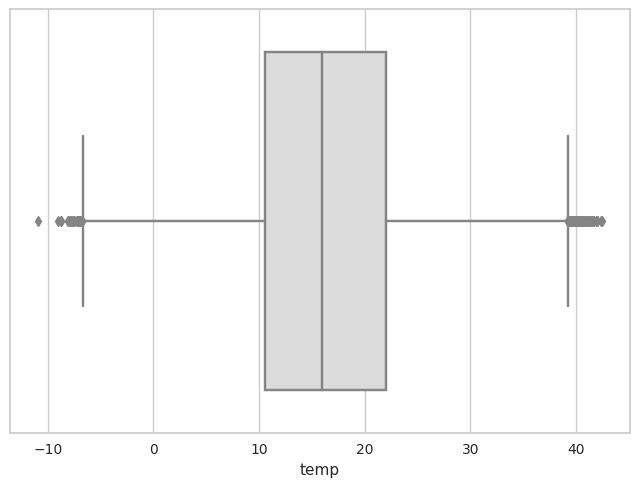

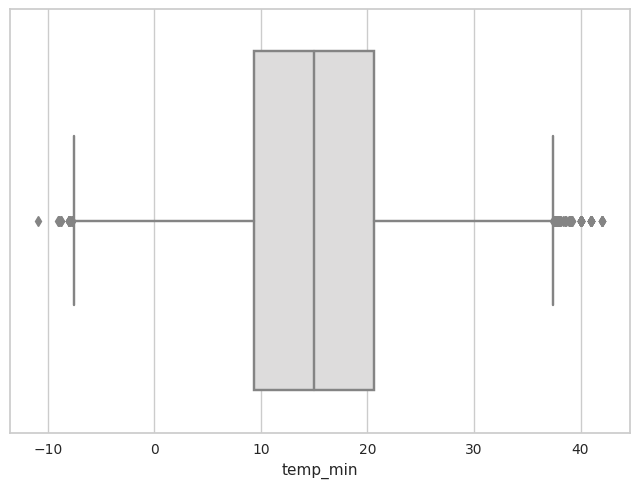

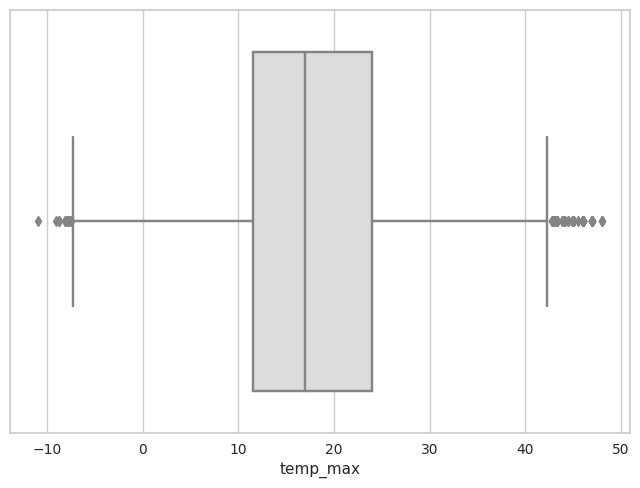

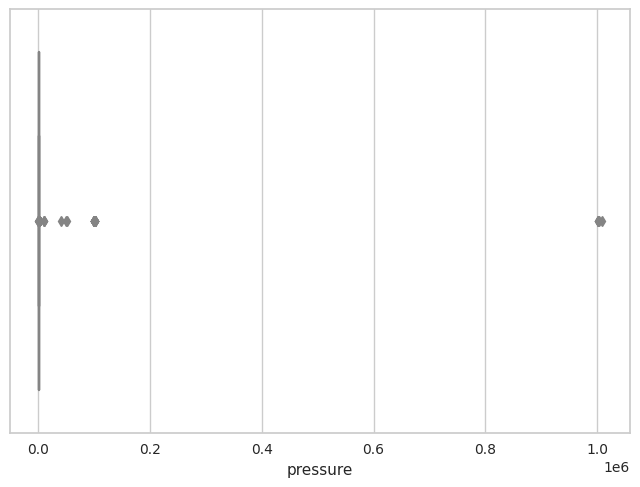

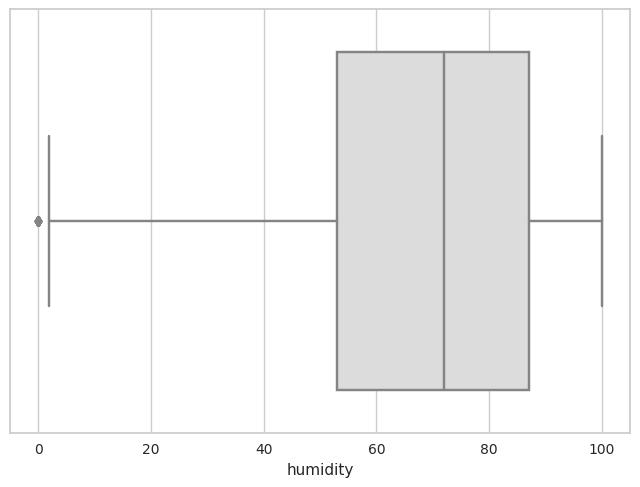

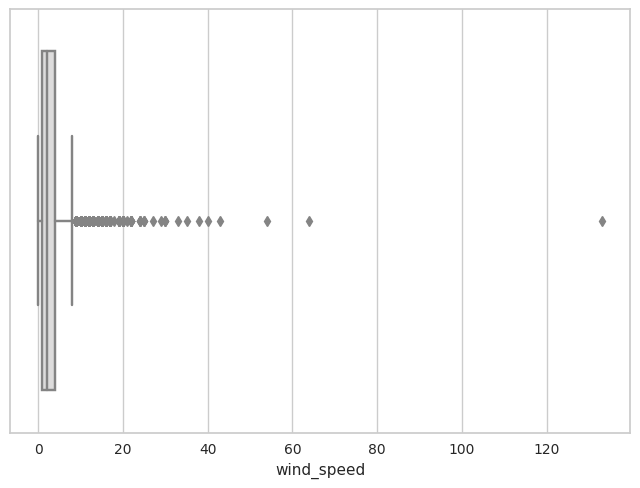

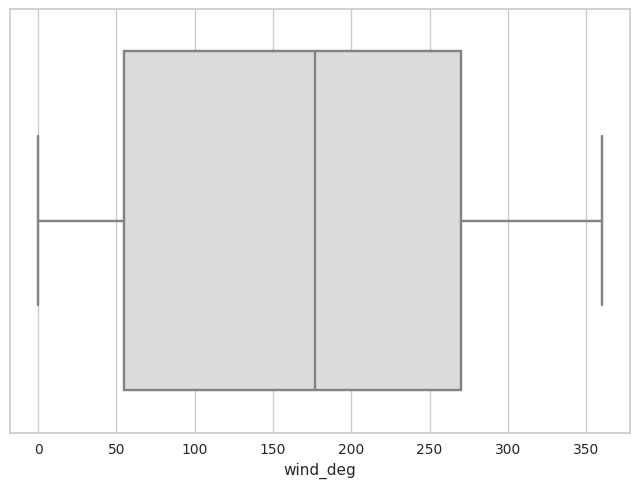

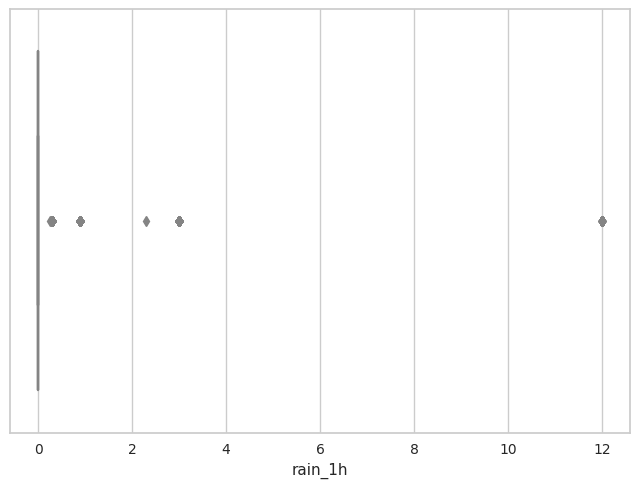

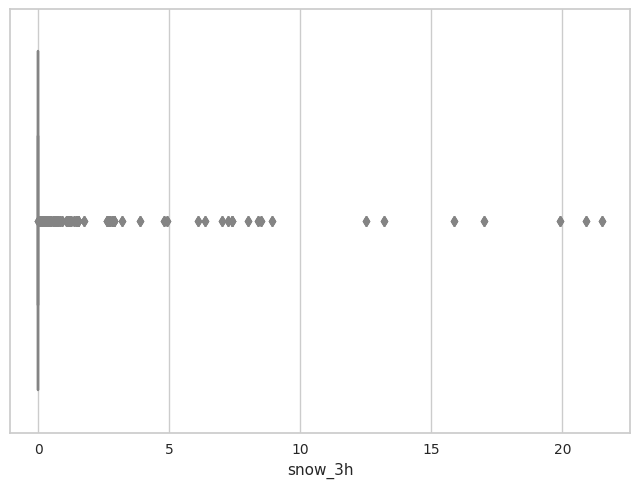

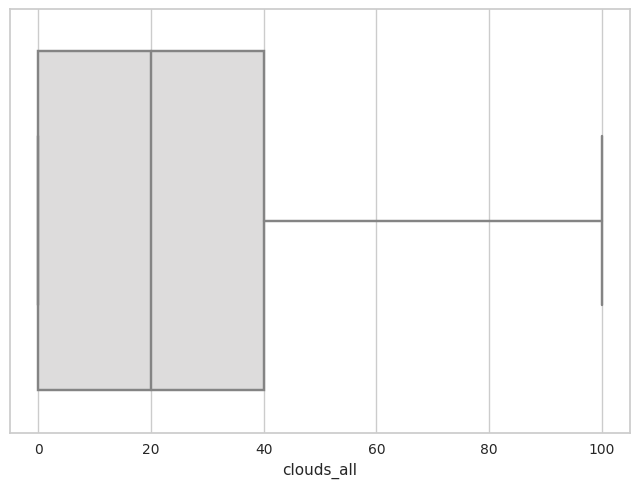

In [42]:
# Boxplots zur Visualisierung der Ausreiser
for i, c in enumerate(f32cols):
    sns.boxplot(x=df1w[c], palette="coolwarm")
    plt.show();

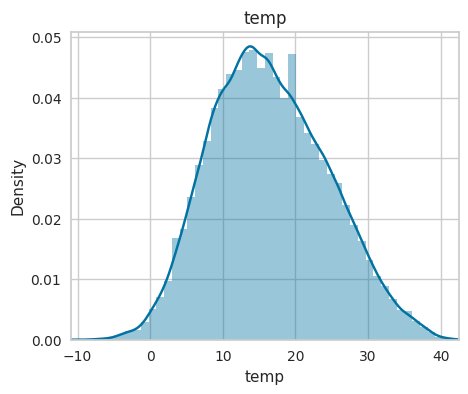

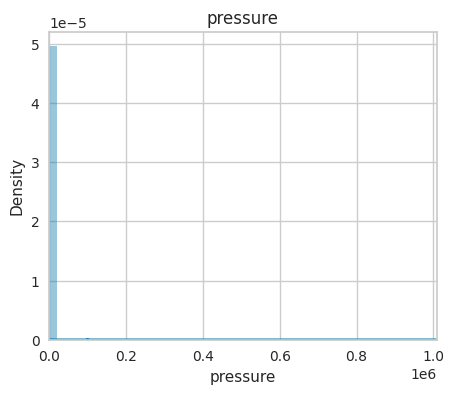

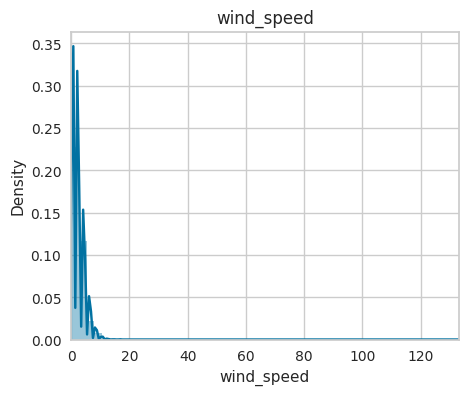

In [43]:
# or use distplot to visualize outliers
fig = plt.figure(figsize=(5, 4)) 
ax = sns.distplot(df1w["temp"])
xmin = df1w["temp"].min()
xmax = df1w["temp"].max()  
ax.set_xlim(xmin, xmax)
ax.set_title("temp");

fig = plt.figure(figsize=(5, 4))
ax = sns.distplot(df1w["pressure"])
xmin = df1w["pressure"].min()
xmax = df1w["pressure"].max()  
ax.set_xlim(xmin, xmax)
ax.set_title("pressure");

fig = plt.figure(figsize=(5, 4))
ax = sns.distplot(df1w["wind_speed"])
xmin = df1w["wind_speed"].min()
xmax = df1w["wind_speed"].max()  
ax.set_xlim(xmin, xmax)
ax.set_title("wind_speed");

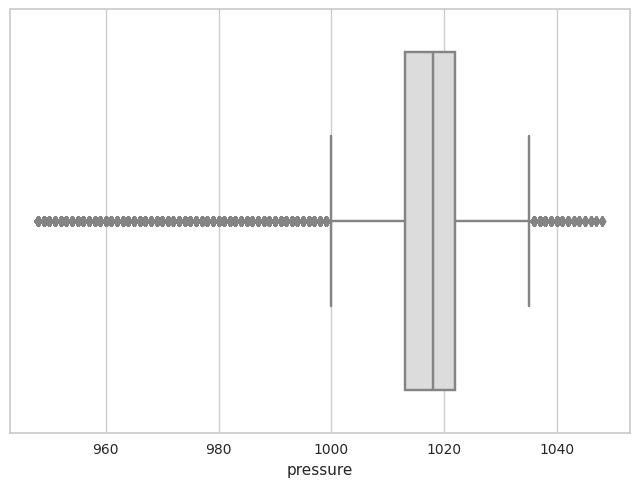

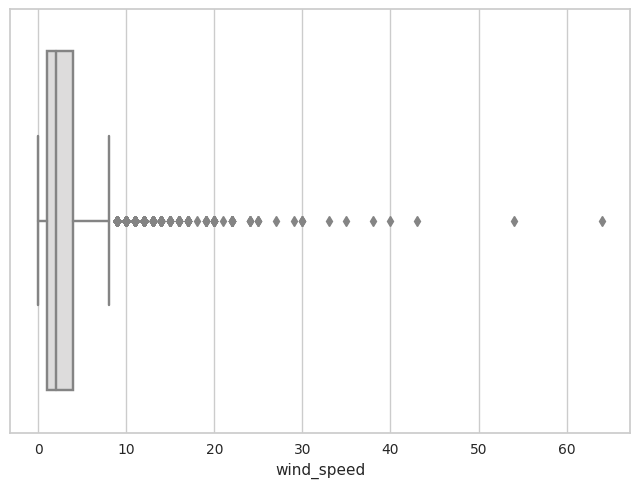

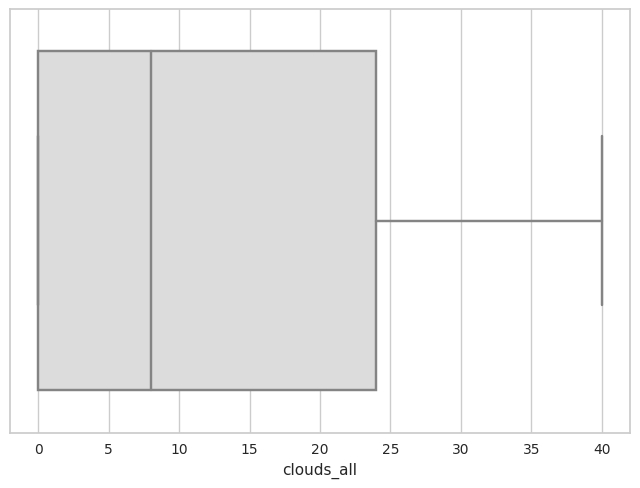

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
count,"178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00","178,396.00"
mean,16.47,15.18,17.94,"1,016.16",68.42,2.47,166.59,0.08,0.00,14.59
std,8.03,7.96,8.61,11.68,21.90,2.07,116.61,0.40,0.22,16.04
min,-10.91,-10.91,-10.91,948.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,10.52,9.33,11.50,"1,013.00",53.00,1.00,55.00,0.00,0.00,0.00
50%,16.00,15.00,17.00,"1,018.00",72.00,2.00,177.00,0.00,0.00,8.00
75%,22.00,20.58,24.00,"1,022.00",87.00,4.00,270.00,0.00,0.00,24.00
max,42.45,42.00,48.00,"1,048.00",100.00,64.00,360.00,12.00,21.50,40.00


In [44]:
# Remove outliers and substitute with interpolation
df1w["pressure"].where(df1w["pressure"] <= 1050, inplace=True)
df1w["pressure"].where(df1w["pressure"] >= 948, inplace=True)
df1w["wind_speed"].where(df1w["wind_speed"] <= 120, inplace=True)
df1w["clouds_all"].where(df1w["clouds_all"] <= 40, inplace=True)
df1w = df1w.interpolate(method ="bfill")

sns.boxplot(x=df1w["pressure"], palette="coolwarm")
plt.show();
sns.boxplot(x=df1w["wind_speed"], palette="coolwarm")
plt.show();
sns.boxplot(x=df1w["clouds_all"], palette="coolwarm")
plt.show();

df1w.describe()

In [45]:
# Check start and ending time of weather and energy datasets
# start and end of energy and weather time series 
print("earliest weather time period:", df1w.index.min())
print("latest weather time period:", df1w.index.max())

print("earliest energy time period:", df1e.index.min())
print("latest energy time period:", df1e.index.max())

earliest weather time period: 2014-12-31 23:00:00+00:00
latest weather time period: 2018-12-31 22:00:00+00:00
earliest energy time period: 2014-12-31 23:00:00+00:00
latest energy time period: 2018-12-31 22:00:00+00:00


In [46]:
# Cities in Spain weather data
cities = df1w["city_name"].unique()
cities

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

In [47]:
# drop duplicate time periods
print("count of duplicates before treatment:",df1w.duplicated(subset=["dt_iso", "city_name"], keep="first").sum())

count of duplicates before treatment: 3076


In [48]:
# Drop the time duplicates
df1w = df1w.drop_duplicates(subset=["dt_iso", "city_name"], keep="first")

# set datetime index
df1w["time"] = pd.to_datetime(df1w["dt_iso"], utc=True, infer_datetime_format=True)
df1w.set_index("time", inplace=True)
df1w.drop("dt_iso", inplace=True, axis=1)

In [49]:
# Check size of the dataframes
print("size of energy dataframe:", df1e.shape[0])
df1w["city_name"] = df1w["city_name"].replace(" Barcelona", "Barcelona")   # remove space in name
dfw1_city = df1w.groupby("city_name")
print("size of city groups in weather dataframe:")
dfw1_city.count()

size of energy dataframe: 35064
size of city groups in weather dataframe:


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
city_name,,,,,,,,,,
Barcelona,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Bilbao,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Madrid,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Seville,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064
Valencia,35064,35064,35064,35064,35064,35064,35064,35064,35064,35064


In [50]:
# Seperate weather data by city
dict_city_weather = {city:df_city for city,df_city in dfw1_city}
dict_city_weather.keys()

dict_keys(['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia'])

In [51]:
# example: Bilbao weather dataframe
dfw_Bilbao = dict_city_weather.get("Bilbao")
print("Bilbao weather:")
dfw_Bilbao.describe()

Bilbao weather:


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
count,"35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00","35,064.00"
mean,13.29,11.84,14.94,"1,017.48",78.73,1.96,159.91,0.12,0.02,22.97
std,6.80,6.82,6.99,9.82,16.71,1.87,122.86,0.37,0.50,16.66
min,-6.30,-9.00,-4.17,961.00,11.00,0.00,0.00,0.00,0.00,0.00
25%,8.30,7.00,10.00,"1,013.00",67.00,1.00,31.00,0.00,0.00,0.00
50%,13.02,11.70,15.00,"1,019.00",82.00,1.00,150.00,0.00,0.00,20.00
75%,17.89,17.00,19.36,"1,024.00",93.00,3.00,290.00,0.00,0.00,40.00
max,39.32,38.89,45.56,"1,042.00",100.00,15.00,360.00,3.00,21.50,40.00


In [52]:
dfw_Bilbao.iloc[[0,-1]]

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
time,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Bilbao,-3.49,-3.49,-3.49,"1,036.00",97.00,0.00,226.00,0.00,0.00,0.00
2018-12-31 22:00:00+00:00,Bilbao,2.45,2.00,3.00,"1,034.00",93.00,2.00,100.00,0.00,0.00,0.00


In [53]:
df1e.head()
# check columns price day ahead

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,gen_oth_renew,gen_solar,gen_waste,gen_wind,load_actual,price_dayahead,price
time,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.00,329.00,"4,844.00","4,821.00",162.00,863.00,"1,051.00","1,899.00","7,096.00",43.00,73.00,49.00,196.00,"6,378.00","25,385.00",50.10,65.41
2015-01-01 00:00:00+00:00,449.00,328.00,"5,196.00","4,755.00",158.00,920.00,"1,009.00","1,658.00","7,096.00",43.00,71.00,50.00,195.00,"5,890.00","24,382.00",48.10,64.92
2015-01-01 01:00:00+00:00,448.00,323.00,"4,857.00","4,581.00",157.00,"1,164.00",973.00,"1,371.00","7,099.00",43.00,73.00,50.00,196.00,"5,461.00","22,734.00",47.33,64.48
2015-01-01 02:00:00+00:00,438.00,254.00,"4,314.00","4,131.00",160.00,"1,503.00",949.00,779.00,"7,098.00",43.00,75.00,50.00,191.00,"5,238.00","21,286.00",42.27,59.32
2015-01-01 03:00:00+00:00,428.00,187.00,"4,130.00","3,840.00",156.00,"1,826.00",953.00,720.00,"7,097.00",43.00,74.00,42.00,189.00,"4,935.00","20,264.00",38.41,56.04


In [54]:
# Merge energy and weather dataframes
df2 = df1e.copy()
for city,df in dict_city_weather.items():
    city_name = str(city) + "_"
    df = df.add_suffix("_{}".format(city))
    df2 = pd.concat([df2, df], axis=1)
    df2.drop("city_name_" + city, inplace=True, axis=1)
print(df2.info())
df2.iloc[[0,-1]]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gen_bio               35064 non-null  float32
 1   gen_lig               35064 non-null  float32
 2   gen_gas               35064 non-null  float32
 3   gen_coal              35064 non-null  float32
 4   gen_oil               35064 non-null  float32
 5   gen_hyd_pump          35064 non-null  float32
 6   gen_hyd_river         35064 non-null  float32
 7   gen_hyd_res           35064 non-null  float32
 8   gen_nuc               35064 non-null  float32
 9   gen_other             35064 non-null  float32
 10  gen_oth_renew         35064 non-null  float32
 11  gen_solar             35064 non-null  float32
 12  gen_waste             35064 non-null  float32
 13  gen_wind              35064 non-null  float32
 14  load_actual           3

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,...,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.00,329.00,"4,844.00","4,821.00",162.00,863.00,"1,051.00","1,899.00","7,096.00",43.00,...,-2.67,-2.67,-2.67,"1,001.00",77.00,1.00,62.00,0.00,0.00,0.00
2018-12-31 22:00:00+00:00,290.00,0.00,"6,926.00","2,166.00",163.00,108.00,"1,069.00","1,686.00","6,075.00",61.00,...,5.99,5.00,7.00,"1,029.00",75.00,2.00,300.00,0.00,0.00,0.00


In [55]:
# limit the dataframe's date range
df2 = df2[df2.index >= "2018-01-01 00:00:00+00:00"]
df2.iloc[[0,-1]]

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,...,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,275.00,0.00,"3,269.00",959.00,191.00,"2,115.00","1,046.00",799.00,"7,057.00",51.00,...,14.00,14.00,14.00,"1,026.00",44.00,5.00,270.00,0.00,0.00,0.00
2018-12-31 22:00:00+00:00,290.00,0.00,"6,926.00","2,166.00",163.00,108.00,"1,069.00","1,686.00","6,075.00",61.00,...,5.99,5.00,7.00,"1,029.00",75.00,2.00,300.00,0.00,0.00,0.00


In [56]:
# any null values?
print("any missing values?", df2.isnull().values.any())

# any ducplicate time periods?
print("count of duplicates:", df2.duplicated(keep="first").sum())

any missing values? False
count of duplicates: 0


### Feature Extraction: Extract Feature to train the forecasting model

#### Correlationanalysis: Check the correlation between the features

In [57]:
df_corr_spear = df2.corr(method="spearman")

In [58]:
df_corrSP = pd.DataFrame(df_corr_spear["price"].sort_values(ascending=False))
df_corrSP

,price
price,1.00
price_dayahead,0.68
gen_gas,0.56
gen_coal,0.47
temp_max_Seville,0.44
...,...
snow_3h_Barcelona,NaN
snow_3h_Bilbao,NaN
snow_3h_Madrid,NaN
snow_3h_Seville,NaN


In [59]:
# highest absolute correlations with price --> min 0.2 (20 %)
correlation_factor = 0.25
pd.options.display.float_format = '{:,.2f}'.format
df_corrSP = df_corrSP[np.abs(df_corrSP["price"]) > correlation_factor]
df_corrSP

,price
price,1.00
price_dayahead,0.68
gen_gas,0.56
gen_coal,0.47
temp_max_Seville,0.44
temp_Seville,0.43
load_actual,0.43
temp_min_Seville,0.43
temp_max_Madrid,0.42
temp_min_Barcelona,0.42


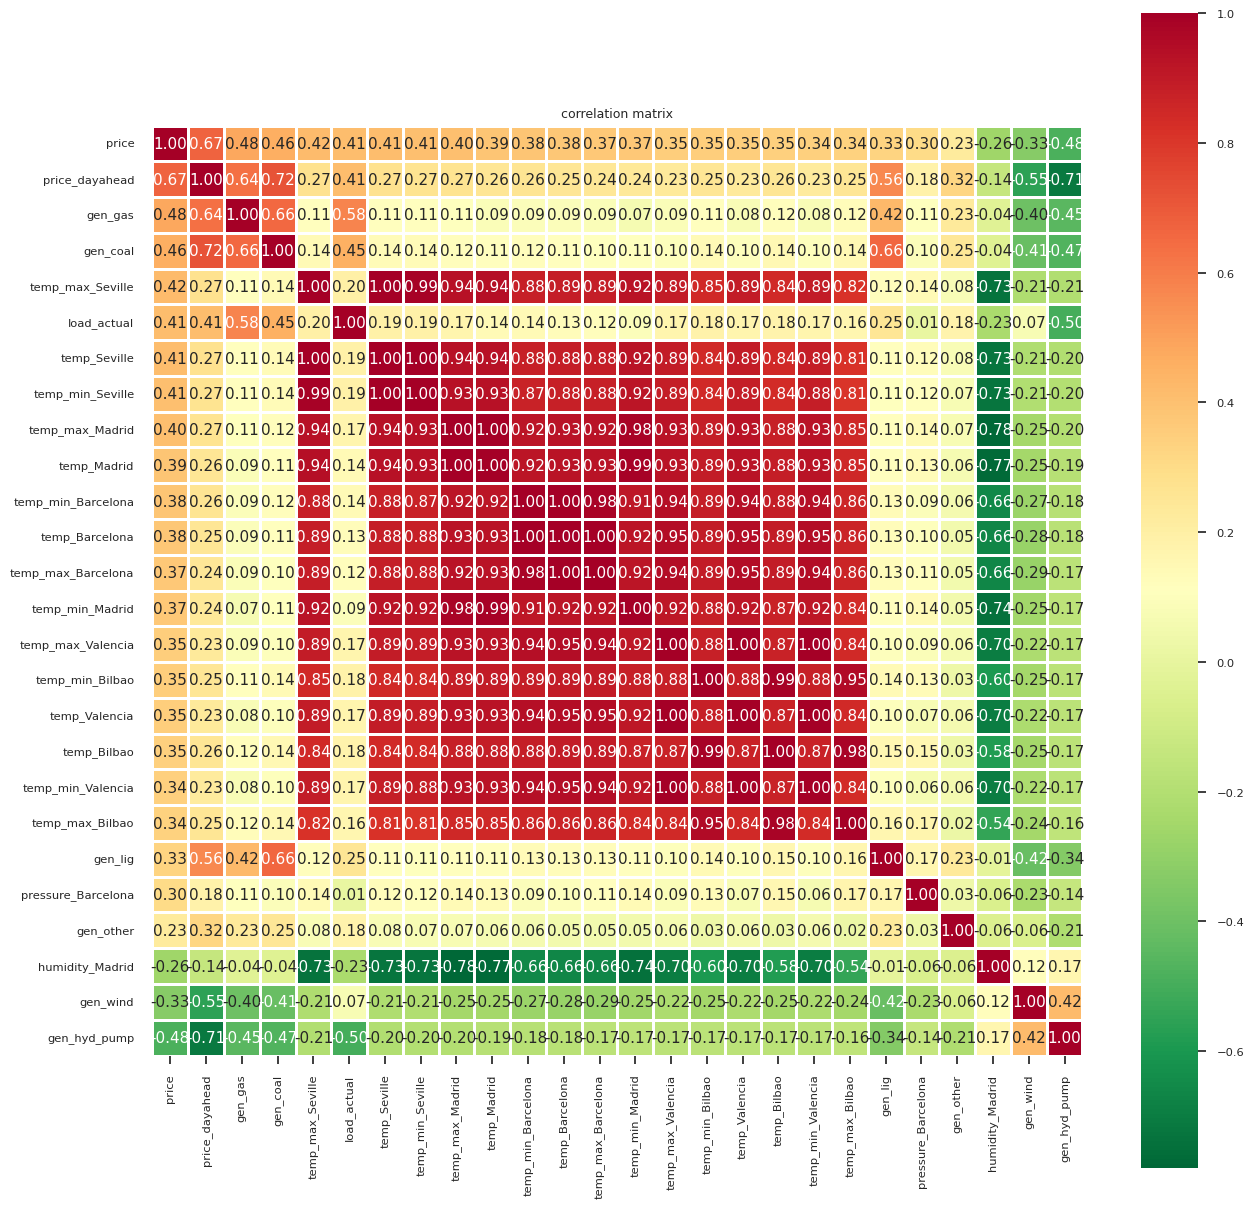

In [60]:
# correlation matrix, limited to highly correlated features
df3 = df2[df_corrSP.index]

idx = df3.corr().sort_values("price", ascending=False).index
df3_sorted = df3.loc[:, idx]  # sort dataframe columns by their correlation with Appliances

plt.figure(figsize = (15,15))
sns.set(font_scale=0.75)
cmap = sns.color_palette("RdYlGn", as_cmap=True).reversed()

ax = sns.heatmap(df3_sorted.corr().round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap=cmap, 
            fmt = ".2f", 
            annot_kws = {"size": 11})
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

In [61]:
df_corr = df2.corr(method="pearson")

In [62]:
df_corr

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,...,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
gen_bio,1.00,0.44,0.22,0.45,0.16,-0.33,-0.44,-0.27,0.29,0.42,...,0.21,0.21,0.21,0.05,0.09,-0.10,-0.11,-0.04,NaN,0.03
gen_lig,0.44,1.00,0.42,0.66,0.27,-0.34,-0.51,-0.22,0.32,0.23,...,0.10,0.10,0.10,0.09,0.20,-0.12,-0.06,0.03,NaN,0.08
gen_gas,0.22,0.42,1.00,0.66,0.41,-0.45,-0.18,0.21,0.03,0.23,...,0.08,0.08,0.09,0.06,0.03,-0.06,-0.10,0.05,NaN,0.04
gen_coal,0.45,0.66,0.66,1.00,0.38,-0.47,-0.50,-0.14,0.24,0.25,...,0.10,0.10,0.10,0.02,0.12,-0.10,-0.07,0.05,NaN,0.07
gen_oil,0.16,0.27,0.41,0.38,1.00,-0.36,-0.06,0.20,0.23,0.26,...,0.08,0.08,0.08,0.00,-0.08,0.00,-0.04,0.03,NaN,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wind_speed_Valencia,-0.10,-0.12,-0.06,-0.10,0.00,0.09,0.09,0.06,-0.01,-0.02,...,0.08,0.08,0.08,-0.23,-0.45,1.00,0.18,0.01,NaN,0.17
wind_deg_Valencia,-0.11,-0.06,-0.10,-0.07,-0.04,0.14,-0.02,-0.08,0.03,-0.02,...,-0.35,-0.35,-0.35,-0.04,0.06,0.18,1.00,0.03,NaN,-0.09
rain_1h_Valencia,-0.04,0.03,0.05,0.05,0.03,-0.01,-0.05,-0.02,0.02,0.04,...,-0.09,-0.09,-0.09,-0.14,0.17,0.01,0.03,1.00,NaN,0.13
snow_3h_Valencia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
print(df_corr.shape)

(67, 67)


In [64]:
print("correlation with price:")

correlation with price:


In [65]:
df_corrP = pd.DataFrame(df_corr["price"].sort_values(ascending=False))
df_corrP

,price
price,1.00
price_dayahead,0.67
gen_gas,0.49
gen_coal,0.46
temp_max_Seville,0.42
...,...
snow_3h_Barcelona,NaN
snow_3h_Bilbao,NaN
snow_3h_Madrid,NaN
snow_3h_Seville,NaN


In [66]:
# highest absolute correlations with price --> min 0.2 (20 %)
correlation_factor = 0.25
pd.options.display.float_format = '{:,.2f}'.format
df_corrH = df_corrP[np.abs(df_corrP["price"]) > correlation_factor]
df_corrH

,price
price,1.00
price_dayahead,0.67
gen_gas,0.49
gen_coal,0.46
temp_max_Seville,0.42
load_actual,0.41
temp_Seville,0.41
temp_min_Seville,0.41
temp_max_Madrid,0.40
temp_Madrid,0.39


In [67]:
df_corrload = pd.DataFrame(df_corr["load_actual"].sort_values(ascending=False))
df_corrload

,load_actual
load_actual,1.00
gen_oil,0.60
gen_gas,0.58
gen_hyd_res,0.49
gen_coal,0.45
...,...
snow_3h_Barcelona,NaN
snow_3h_Bilbao,NaN
snow_3h_Madrid,NaN
snow_3h_Seville,NaN


In [68]:
correlation_factor = 0.25
pd.options.display.float_format = '{:,.2f}'.format
df_corrloadH = df_corrload[np.abs(df_corrload["load_actual"]) > correlation_factor]
df_corrloadH

,load_actual
load_actual,1.00
gen_oil,0.60
gen_gas,0.58
gen_hyd_res,0.49
gen_coal,0.45
gen_solar,0.42
price,0.41
price_dayahead,0.41
gen_lig,0.25
humidity_Bilbao,-0.28


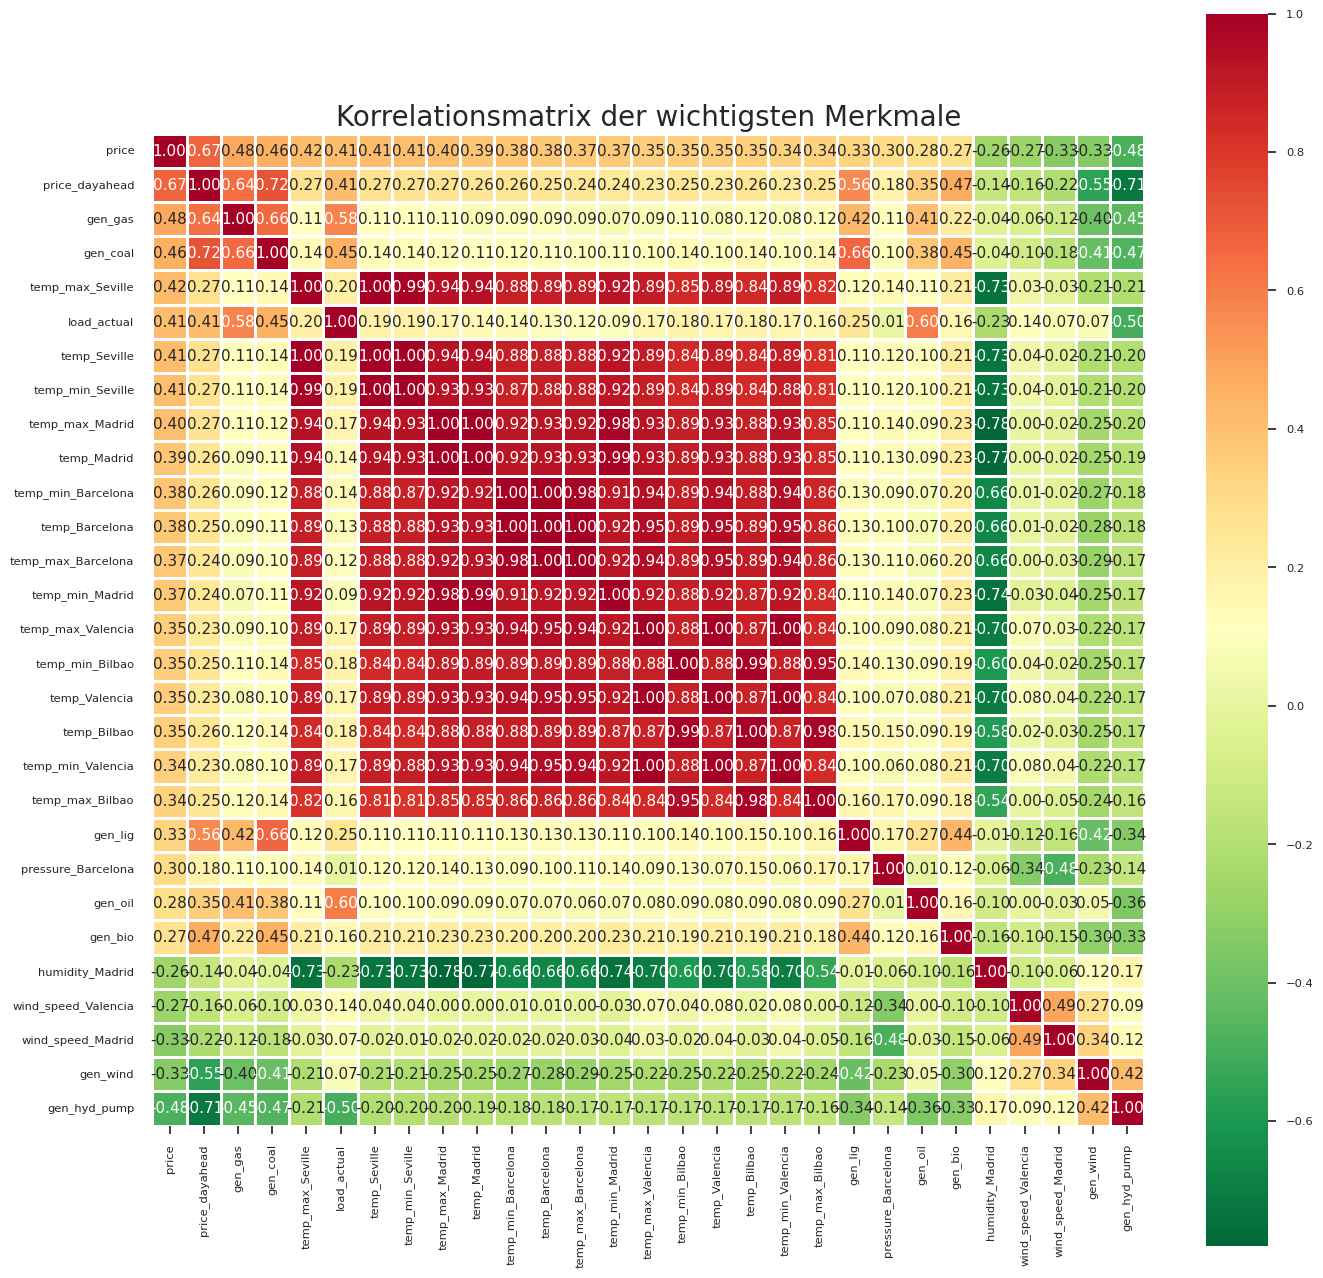

In [49]:
# correlation matrix, limited to highly correlated features
df3 = df2[df_corrH.index]

idx = df3.corr().sort_values("price", ascending=False).index
df3_sorted = df3.loc[:, idx]  # sort dataframe columns by their correlation with Appliances
cmap = sns.color_palette("RdYlGn", as_cmap=True).reversed()

plt.figure(figsize = (16,16))
sns.set(font_scale=0.75)
ax = sns.heatmap(df3_sorted.corr().round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap=cmap, 
            fmt = ".2f", 
            annot_kws = {"size": 11})
ax.xaxis.tick_bottom()
plt.title("Korrelationsmatrix der wichtigsten Merkmale", fontsize=20)
plt.show()

In [50]:
# Choose data for training and testing
df = df3.copy()

In [50]:
df_sep = df2.reset_index()
df_sep = df_sep[df_sep["time"].dt.month_name() == "September"]
df_sep = df_sep.set_index("time")
df_sep

,gen_bio,gen_lig,gen_gas,gen_coal,gen_oil,gen_hyd_pump,gen_hyd_river,gen_hyd_res,gen_nuc,gen_other,...,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
time,,,,,,,,,,,,,,,,,,,,,
2018-09-01 00:00:00+00:00,280.00,936.00,"4,826.00","6,109.00",342.00,573.00,"1,033.00","1,138.00","6,081.00",49.00,...,25.00,25.00,25.00,"1,018.00",78.00,2.00,330.00,0.00,0.00,40.00
2018-09-01 01:00:00+00:00,281.00,801.00,"4,970.00","5,509.00",342.00,656.00,"1,025.00","1,178.00","6,082.00",49.00,...,25.00,25.00,25.00,"1,018.00",78.00,2.00,340.00,0.00,0.00,40.00
2018-09-01 02:00:00+00:00,283.00,694.00,"4,685.00","5,246.00",334.00,806.00,"1,015.00","1,006.00","6,082.00",49.00,...,24.00,24.00,24.00,"1,018.00",78.00,2.00,330.00,0.00,0.00,20.00
2018-09-01 03:00:00+00:00,282.00,744.00,"4,766.00","5,200.00",342.00,937.00,"1,028.00","1,118.00","6,083.00",48.00,...,24.00,24.00,24.00,"1,018.00",78.00,2.00,330.00,0.00,0.00,20.00
2018-09-01 04:00:00+00:00,286.00,855.00,"5,215.00","5,776.00",338.00,680.00,"1,031.00","1,222.00","6,083.00",49.00,...,23.00,23.00,23.00,"1,018.00",83.00,2.00,320.00,0.00,0.00,20.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00+00:00,355.00,704.00,"4,141.00","4,049.00",245.00,0.00,623.00,"1,294.00","7,000.00",60.00,...,23.00,23.00,23.00,"1,016.00",64.00,1.00,120.00,0.00,0.00,20.00
2018-09-30 20:00:00+00:00,354.00,610.00,"3,988.00","3,654.00",239.00,14.00,560.00,927.00,"7,002.00",60.00,...,23.00,23.00,23.00,"1,016.00",69.00,1.00,20.00,0.00,0.00,0.00
2018-09-30 21:00:00+00:00,347.00,572.00,"3,950.00","3,331.00",247.00,383.00,552.00,574.00,"7,002.00",59.00,...,22.00,22.00,22.00,"1,017.00",73.00,2.00,350.00,0.00,0.00,0.00


In [51]:
df_corr_sep = df_sep.corr(method="pearson")

In [52]:
df_corr_sepp = pd.DataFrame(df_corr_sep["price"].sort_values(ascending=False))
df_corr_sepp

,price
price,1.00
gen_gas,0.55
gen_hyd_res,0.52
load_actual,0.51
price_dayahead,0.48
...,...
snow_3h_Barcelona,NaN
snow_3h_Bilbao,NaN
snow_3h_Madrid,NaN
snow_3h_Seville,NaN


In [53]:
# highest absolute correlations with price --> min 0.2 (20 %)
correlation_factor = 0.25
pd.options.display.float_format = '{:,.2f}'.format
df_corr_sepp = df_corr_sepp[np.abs(df_corr_sepp["price"]) > correlation_factor]
df_corr_sepp

,price
price,1.00
gen_gas,0.55
gen_hyd_res,0.52
load_actual,0.51
price_dayahead,0.48
gen_oth_renew,0.43
temp_min_Bilbao,0.37
temp_Bilbao,0.37
temp_max_Bilbao,0.35
gen_solar,0.30


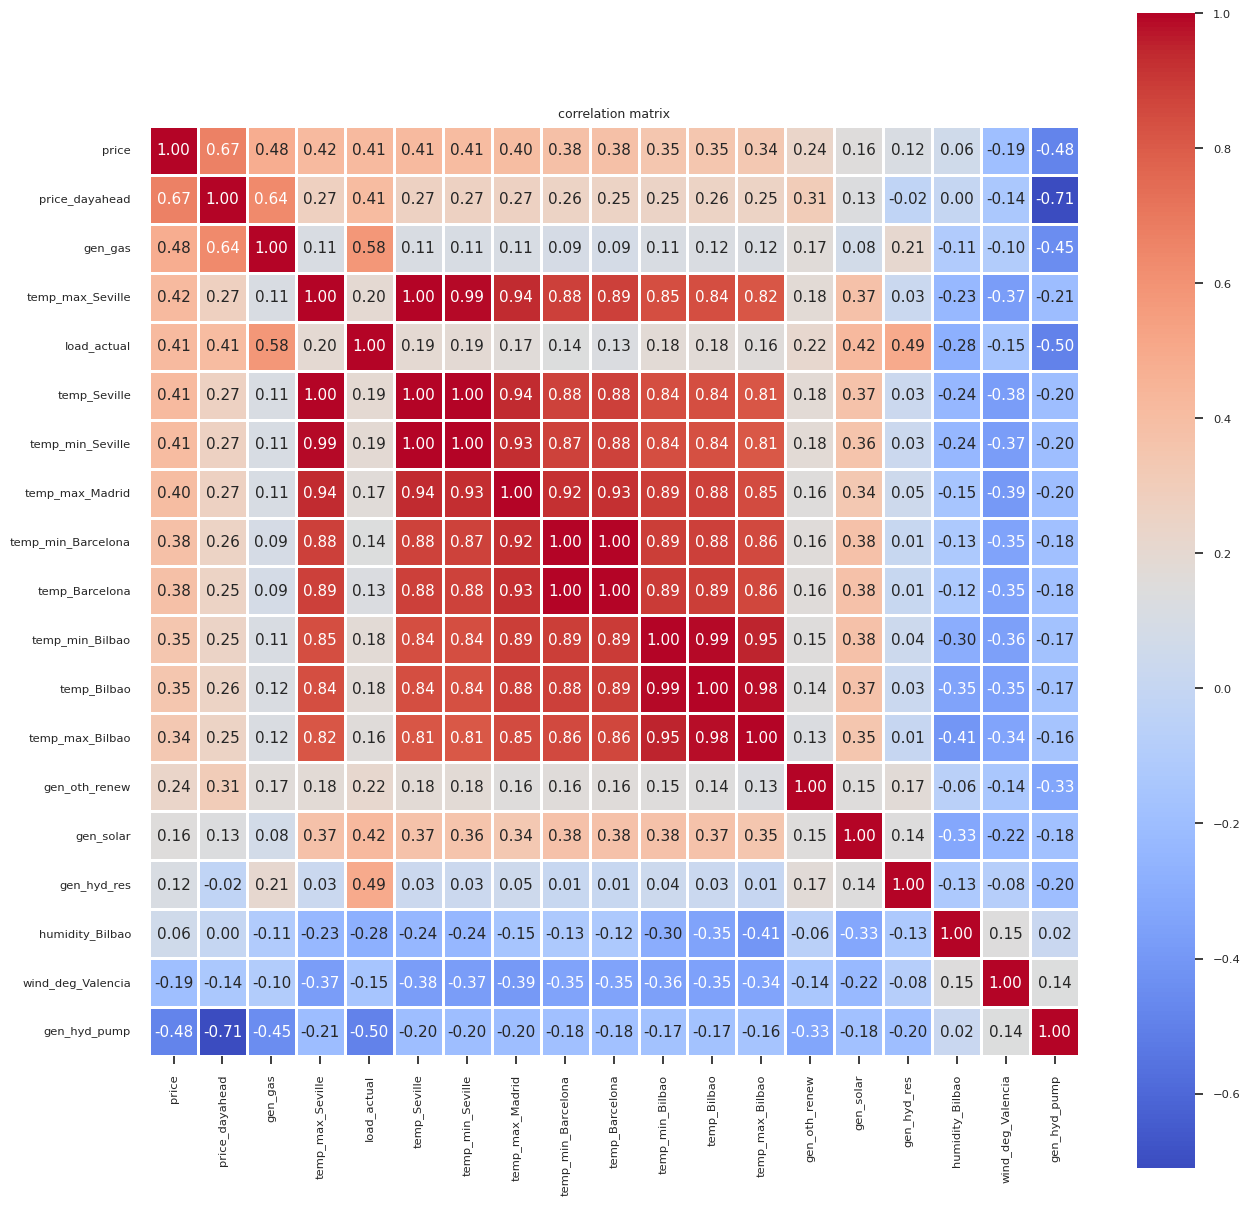

In [54]:
# correlation matrix, limited to highly correlated features
df4 = df2[df_corr_sepp.index]

idx = df4.corr().sort_values("price", ascending=False).index
df4_sorted = df4.loc[:, idx]  # sort dataframe columns by their correlation with Appliances

plt.figure(figsize = (15,15))
sns.set(font_scale=0.75)
ax = sns.heatmap(df4_sorted.corr().round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap="coolwarm", 
            fmt = ".2f", 
            annot_kws = {"size": 11})
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

## Check: Trend and Seasonality

In [111]:
# additional datetime columns: feature engineering
df3["Monat_int"] = df3.index.month
# dict_months = {1:"1_Jan", 2:"2_Feb", 3:"3_Mär", 4:"4_Apr", 5:"5_Mai", 6:"6_Jun", 7:"7_Jul", 8:"8_Aug", 9:"9_Sep", 10:"10_Okt", 11:"11_Nov", 12:"12_Dez"}
# df3["Monat"] = df3["Monat_int"].apply(lambda x: dict_months[x])
df3["wday"] = df3.index.dayofweek
dict_days = {0:"1_Mon", 1:"2_Die", 2:"3_Mit", 3:"4_Don", 4:"5_Fre", 5:"6_Sam", 6:"7_Son"}
df3["Wochentag"] = df3["wday"].apply(lambda x: dict_days[x])

df3["Stunde"] = df3.index.hour

df3 = df3.astype({"Stunde":float, "wday":float}) #, "Monat": float})

df3.iloc[[0, -1]]

,price,gen_gas,gen_hyd_res,load_actual,price_dayahead,gen_oth_renew,temp_min_Bilbao,temp_Bilbao,temp_max_Bilbao,gen_solar,...,temp_Barcelona,temp_min_Seville,humidity_Bilbao,wind_deg_Valencia,gen_hyd_pump,Monat,wday,Wochentag,Stunde,Monat_int
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,19,"3,269",799,"22,009",5,77,4,8,12,9,...,14,10,46,270,"2,115",1_Jan,0,1_Mon,0,1
2018-12-31 22:00:00+00:00,70,"6,926","1,686","24,455",64,92,2,2,3,31,...,7,9,93,300,108,12_Dez,0,1_Mon,22,12


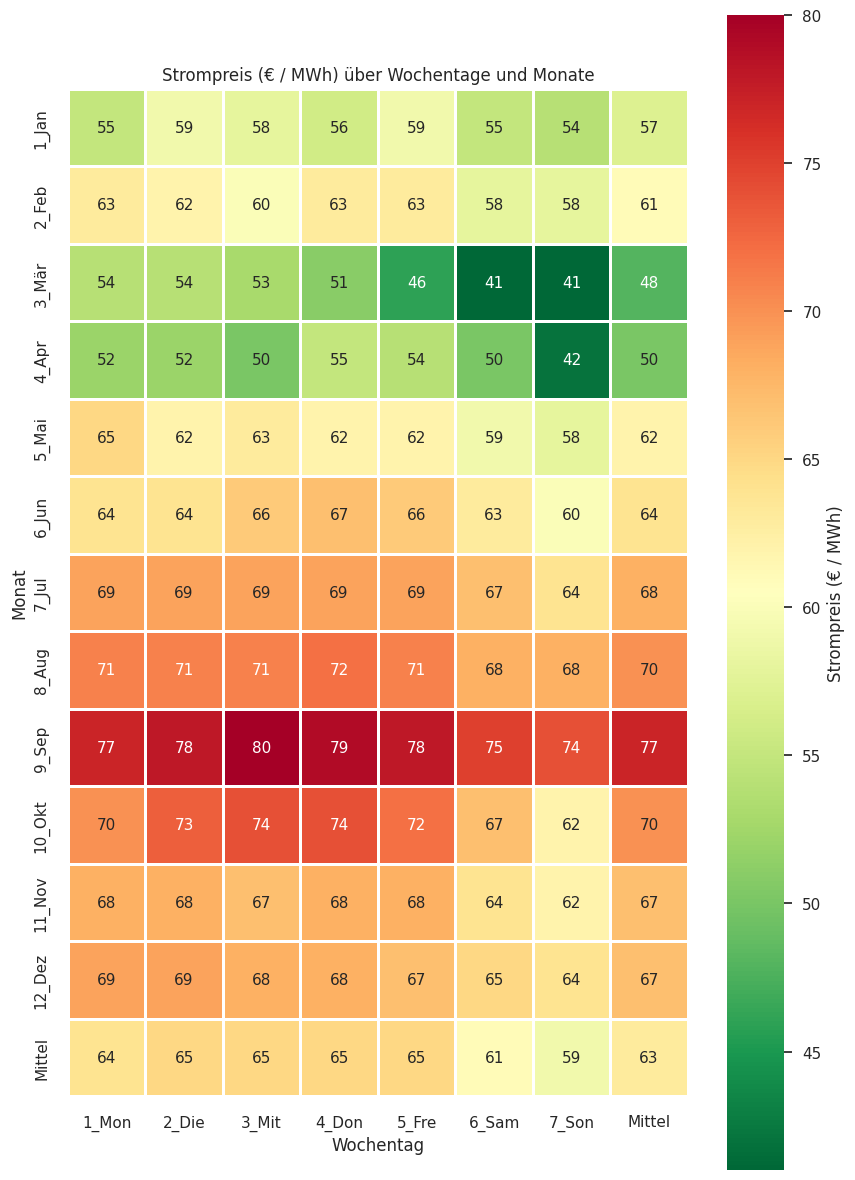

In [131]:
# pivot table: weekdays in months
piv = pd.pivot_table(   df3, 
                        values="price", 
                        index="Monat_int", 
                        columns="Wochentag", 
                        aggfunc="mean", 
                        margins=True, margins_name="Mittel", 
                        fill_value=0)
pd.options.display.float_format = '{:,.0f}'.format
piv.index = piv.index.rename("Monat")
# piv = piv.rename(index= {1: "Jan", 2: "Feb", 3: "Mär", 4: "Apr", 5: "Mai", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Okt", 11: "Nov", 12: "Dez", "Mittelwert": "Mittel"})
piv = piv.rename(index= {1:"1_Jan", 2: "2_Feb", 3: "3_Mär", 4: "4_Apr", 5: "5_Mai", 6: "6_Jun", 7: "7_Jul", 8: "8_Aug", 9: "9_Sep", 10: "10_Okt", 11: "11_Nov", 12: "12_Dez", "Mittelwert": "Mittel"})

plt.figure(figsize = (10,15))
sns.set(font_scale=1)
cmap = sns.color_palette("RdYlGn", as_cmap=True).reversed()
sns.heatmap(piv.round(0), annot=True, square = True, \
            linewidths=.75, cmap=cmap, fmt = ".0f", annot_kws = {"size": 11}, cbar_kws={'label': 'Strompreis (€ / MWh)'})
plt.title("Strompreis (€ / MWh) über Wochentage und Monate")
plt.show()

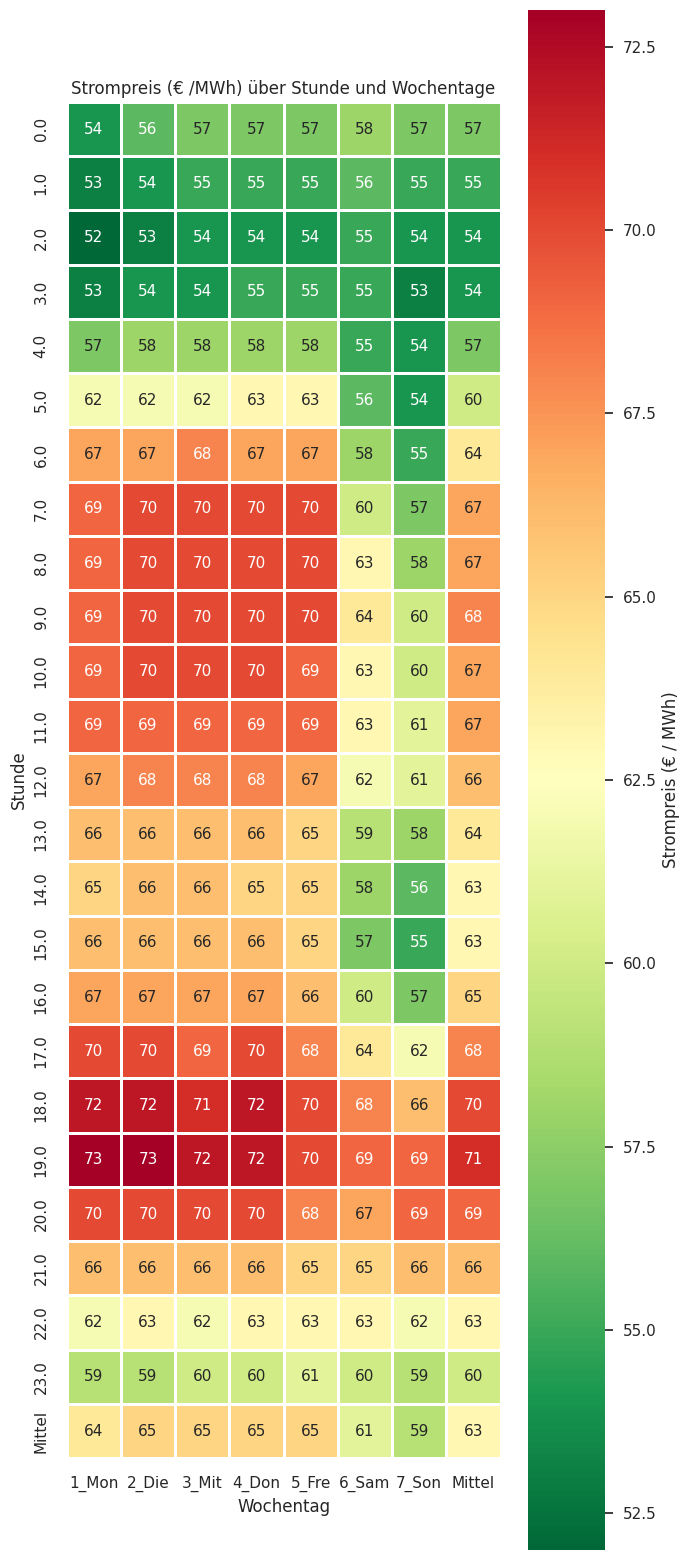

In [129]:
# pivot table: hours in weekdays
piv = pd.pivot_table(   df3, 
                        values="price", 
                        index="Stunde", 
                        columns="Wochentag", 
                        aggfunc="mean", 
                        margins=True, margins_name="Mittel", 
                        fill_value=0)
pd.options.display.float_format = '{:,.0f}'.format

plt.figure(figsize = (7,20))
sns.set(font_scale=1)
sns.heatmap(piv.round(0), annot=True, square = True, \
            linewidths=.75, cmap=cmap, fmt = ".0f", annot_kws = {"size": 11}, cbar_kws={'label': 'Strompreis (€ / MWh)'})
plt.title("Strompreis (€ /MWh) über Stunde und Wochentage")
# colorbar = ax.collections[0].colorbar
# colorbar.set_label("€ / MWh")
plt.show()


## Prepare the dataset for the training

In [55]:
%load_ext autoreload

#bs change for test 2
#Reload all modules before executing the Python code typed.
%autoreload 2

In [50]:
df = df.reset_index()

In [51]:
df.to_csv("train_df.csv")

In [85]:
df = pd.read_csv("/workspaces/TSF/example_usage/energy/train_df.csv", header=0, parse_dates=["time"])
# df = df.set_index("time")
df = df.drop(columns=["Unnamed: 0"])

TypeError: read_csv() got an unexpected keyword argument 'ucits'

In [4]:
# Parameters
date_column = "time"
label_column = "price" #if aggregating then add _aggregationMethod (eg. "sales_sum")

time_format = "%Y-%m-%d %H:%M:%S" #format guideline https://strftime.org/ -> eg. 2016-01-06 00:00:00 would be "%Y-%m-%d %H:%M:%S"

# Config = None
# Preprocess config
frequency = 'H'
aggregate = False

# Train config
FcHorizon = 24
exogen = True
effort = 3
metric = "SMAPE" 
out_of_sample = False
choose_optimizer = "all"
ebm_only = True
blend_models = False

# Explain config
explainibility_on = True
explain_global = True
explain_local = True

In [5]:
# --------------------------------------------- TSF Workflow --------------------------------------------------------

tsf = TSF(
    data = df,
    frequency = frequency,
    date_column=date_column,
    label_column = label_column,
    title = "title")

tsf.preprocess(
format = time_format,
exogen = exogen,
normalize = False,
aggregate=aggregate,
all_mean=True,)

tsf.select_best_model(
    FcHorizon,
    effort = effort,
    metric = metric,
    out_of_sample = out_of_sample,
    choose_optimizer=choose_optimizer,
    blend_best_model=blend_models,
    quick_interpret_result=ebm_only,
    explainable_models=explainibility_on,)
    # future_data_exogen = future_data_exogen)


print("Train:", len(tsf.train_data))
print("Test:", len(tsf.test_data))
print("Future:", len(tsf.future_data))


,Description,Value
0,Session id,3792
1,Target,price
2,Target type,Regression
3,Data shape,"(8735, 35)"
4,Train data shape,"(8711, 35)"
5,Test data shape,"(24, 35)"
6,Numeric features,35
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,17.3356,383.0106,19.5707,-2.8083,0.4320,0.2912,0.3584
1,5.2737,40.4859,6.3629,0.1716,0.0886,0.0761,0.0736
2,9.2611,115.2783,10.7368,-0.5279,0.1559,0.1454,0.1326
Mean,10.6235,179.5916,12.2234,-1.0548,0.2255,0.1709,0.1882
Std,5.0176,147.0441,5.4936,1.2723,0.1486,0.0896,0.1227


RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe


SMAPE of best Model: 0.3584
Train: 8711
Test: 24
Future: 24


In [58]:
# # Preprocess Feature: Arbeitstage pro Woche
# calendar_path = r'../example_usage/cats/Fabrikkalender.csv'
# calendar_data = pd.read_csv(calendar_path, sep=";")
# calendar_data = calendar_data.drop(columns=["JAHR", "Tag", "Monat"])
# calendar_data["Datum"] = pd.to_datetime(
#                     calendar_data["Datum"], format="%d.%m.%Y", utc=False
#                 )
# calendar_data.set_index("Datum", inplace=True)
# calendar_data = calendar_data.groupby(pd.Grouper(freq=frequency)).sum()

In [59]:
# # Select data: Slice DataFrame based on Date index
# original_data = original_data.set_index(date_column)
# original_data = original_data['11.08.2016' :'31.03.2023']
# train_calendar_data = calendar_data['2016-08-11' :'2023-03-31']
# original_data = original_data.reset_index()
# # Convert strings to floats
# original_data[label_column] = original_data[label_column].str.replace(',', '.', regex=True).astype(float)

In [60]:
tsf = TSF(
    data = df,
    frequency = frequency,
    date_column=date_column,
    label_column = label_column,
    title = "title")

tsf.preprocess(
format = time_format,
exogen = exogen,
normalize = False,
aggregate=aggregate,
all_mean=True,)


tsf.select_best_model(
    FcHorizon,
    effort = effort,
    metric = metric,
    out_of_sample = out_of_sample,
    choose_optimizer=choose_optimizer,
    blend_best_model=blend_models,
    quick_interpret_result=ebm_only,
    explainable_models=explainibility_on,)
    # future_data_exogen = future_data_exogen)


print("Train:", len(tsf.train_data))
print("Test:", len(tsf.test_data))
print("Future:", len(tsf.future_data))


,Description,Value
0,Session id,333
1,Target,price
2,Target type,Regression
3,Data shape,"(8735, 35)"
4,Train data shape,"(8711, 35)"
5,Test data shape,"(24, 35)"
6,Numeric features,35
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,17.3356,383.0106,19.5707,-2.8083,0.4320,0.2912,0.3584
1,5.2737,40.4859,6.3629,0.1716,0.0886,0.0761,0.0736
2,9.2611,115.2783,10.7368,-0.5279,0.1559,0.1454,0.1326
Mean,10.6235,179.5916,12.2234,-1.0548,0.2255,0.1709,0.1882
Std,5.0176,147.0441,5.4936,1.2723,0.1486,0.0896,0.1227


RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe
RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe


SMAPE of best Model: 0.3584
Train: 8711
Test: 24
Future: 24


couldn't / didn't need to drop label column
couldn't / didn't need to drop label column
---------------------------------------------------------------------
Forecast with SMAPE: 0.3584 
Optimizer Used: <TSF_Package.Auto_ML.Optimizer._Pycaret_Regression_Optimizer._Pycaret_Regression_Optimizer object at 0x7f228dc9bb20> with model ExplainableBoostingRegressor(feature_names=['price_dayahead', 'gen_gas',
                                            'gen_coal', 'temp_max_Seville',
                                            'load_actual', 'temp_Seville',
                                            'temp_min_Seville',
                                            'temp_max_Madrid', 'temp_Madrid',
                                            'temp_min_Barcelona',
                                            'temp_Barcelona',
                                            'temp_max_Barcelona',
                                            'temp_min_Madrid',
                                            't

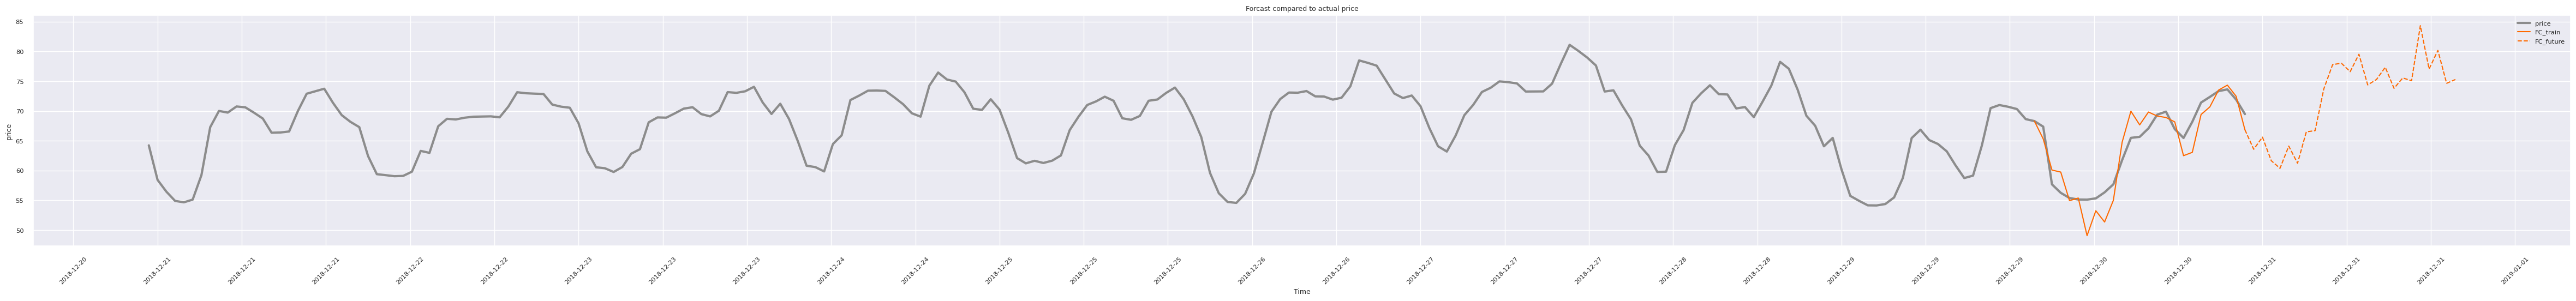

In [61]:
tsf.visualize(saveToFile=False, ratio=2)

In [93]:
pred1 = tsf.AutoML.best_optimizer.predict(on_final=False, fh = FcHorizon)
pred2 = tsf.AutoML.best_optimizer.predict(on_final=True, fh = FcHorizon)
pred = pd.concat([pred1, pred2], axis=0)

couldn't / didn't need to drop label column
couldn't / didn't need to drop label column


# Explainible AI

In [6]:
from interpret import show, show_link
if explainibility_on:
    explanations = tsf.interpret_ml(
        interpret_data = tsf.test_data.iloc[-24:, :],
        explain_global = explain_global,
        explain_local = explain_local,)

In [7]:
show_link(explanations["global_object"])

'http://127.0.0.1:7001/140200171845184/'

In [8]:
show_link(explanations["local_object"])

'http://127.0.0.1:7001/140198591354528/'

### Strombedarf über Monate

In [15]:
df_load = tsf.data.groupby("f_month").sum()["load_actual"]

In [20]:
df_load

f_month
1    22,077,336.00
2    20,369,942.00
3    21,899,244.00
4    20,077,850.00
5    20,850,559.00
6    21,061,878.00
7    22,027,510.00
8    21,626,073.00
9    20,999,662.00
10   20,894,072.00
11   21,207,856.00
12   21,494,087.00
Name: load_actual, dtype: float64

# Show predictions

In [88]:
actual = tsf.test_data.iloc[-24:, :]["price"]

In [89]:
actual

time
2018-12-29 23:00:00   67.38
2018-12-30 00:00:00   57.69
2018-12-30 01:00:00   56.27
2018-12-30 02:00:00   55.40
2018-12-30 03:00:00   55.15
2018-12-30 04:00:00   55.13
2018-12-30 05:00:00   55.34
2018-12-30 06:00:00   56.35
2018-12-30 07:00:00   57.70
2018-12-30 08:00:00   61.77
2018-12-30 09:00:00   65.50
2018-12-30 10:00:00   65.67
2018-12-30 11:00:00   67.09
2018-12-30 12:00:00   69.40
2018-12-30 13:00:00   69.90
2018-12-30 14:00:00   66.97
2018-12-30 15:00:00   65.48
2018-12-30 16:00:00   68.20
2018-12-30 17:00:00   71.43
2018-12-30 18:00:00   72.37
2018-12-30 19:00:00   73.35
2018-12-30 20:00:00   73.64
2018-12-30 21:00:00   71.92
2018-12-30 22:00:00   69.49
Freq: H, Name: price, dtype: float64

In [94]:
pred1 = pred1.rename(columns={"price": "price_pred"})

In [95]:
concat_df = pd.concat([actual, pred1], axis=1)

In [96]:
concat_df

,price,price_pred
time,,
2018-12-29 23:00:00,67.38,65.33
2018-12-30 00:00:00,57.69,60.09
2018-12-30 01:00:00,56.27,59.76
2018-12-30 02:00:00,55.40,54.95
2018-12-30 03:00:00,55.15,55.40
2018-12-30 04:00:00,55.13,49.08
2018-12-30 05:00:00,55.34,53.26
2018-12-30 06:00:00,56.35,51.37
2018-12-30 07:00:00,57.70,55.02


In [105]:
from sklearn.metrics import mean_absolute_percentage_error
mape_pred = mean_absolute_percentage_error(concat_df["price"], concat_df["price_pred"])
print("MAPE: ", mape_pred*100, "%")

MAPE:  3.6760982928633017 %


In [99]:
# a = concat_df.reset_index()
# a["time_new"] = a["time"].dt.time


In [100]:
a = concat_df.reset_index()
a["time_new"] = a["time"].dt.time

a = a.set_index("time_new")
a = a.reset_index()
a["time_new"] = a["time_new"].astype(str)

In [101]:
# a = a.reset_index()

In [102]:
# a["time_new"] = a["time_new"].astype(str)

In [103]:
a["time_new"]

0     23:00:00
1     00:00:00
2     01:00:00
3     02:00:00
4     03:00:00
5     04:00:00
6     05:00:00
7     06:00:00
8     07:00:00
9     08:00:00
10    09:00:00
11    10:00:00
12    11:00:00
13    12:00:00
14    13:00:00
15    14:00:00
16    15:00:00
17    16:00:00
18    17:00:00
19    18:00:00
20    19:00:00
21    20:00:00
22    21:00:00
23    22:00:00
Name: time_new, dtype: object

## Plot the forecasted energy prices and the calculated error (MAPE) vs. the ground truth

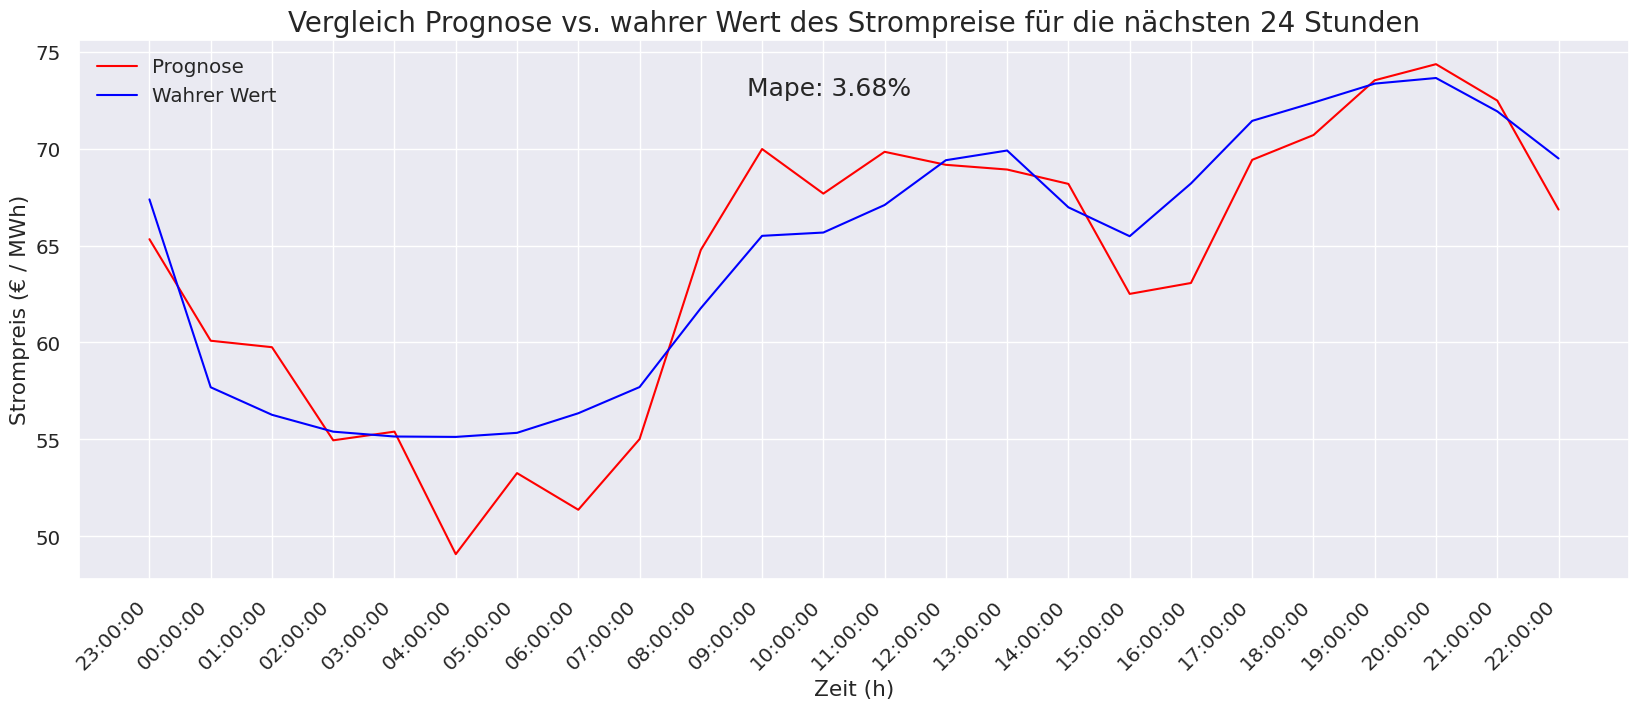

In [204]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
sns.set_style("darkgrid") 
sns.lineplot(x = a["time_new"], y = a["price_pred"], color="red", label="Prognose")
sns.lineplot(x = a["time_new"], y = a["price"], color="blue", label="Wahrer Wert")
plt.title("Vergleich Prognose vs. wahrer Wert des Strompreise für die nächsten 24 Stunden", fontsize=20)
plt.xlabel("Zeit (h)")
plt.ylabel("Strompreis (€ / MWh)")
plt.figtext(.5, .8, "MAPE: " + str(round(mape_pred*100, 2)) + "%", fontsize=18, ha='center')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left')

In [76]:
df_tso = df.set_index("time")

In [78]:
df_tso["price_dayahead"]

time
2018-01-01 00:00:00+00:00    4.74
2018-01-01 01:00:00+00:00    3.66
2018-01-01 02:00:00+00:00    2.30
2018-01-01 03:00:00+00:00    2.30
2018-01-01 04:00:00+00:00    2.06
                             ... 
2018-12-31 18:00:00+00:00   68.85
2018-12-31 19:00:00+00:00   68.40
2018-12-31 20:00:00+00:00   66.88
2018-12-31 21:00:00+00:00   63.93
2018-12-31 22:00:00+00:00   64.27
Name: price_dayahead, Length: 8759, dtype: float64

In [83]:
df_tso = df_tso[df_tso.index >= "2018-12-29 23:00:00+00:00"]
df_tso = df_tso[df_tso.index <= "2018-12-30 22:00:00+00:00"]

#2018-12-29 23:00:00

In [111]:
concat_df.index

DatetimeIndex(['2018-12-29 23:00:00', '2018-12-30 00:00:00',
               '2018-12-30 01:00:00', '2018-12-30 02:00:00',
               '2018-12-30 03:00:00', '2018-12-30 04:00:00',
               '2018-12-30 05:00:00', '2018-12-30 06:00:00',
               '2018-12-30 07:00:00', '2018-12-30 08:00:00',
               '2018-12-30 09:00:00', '2018-12-30 10:00:00',
               '2018-12-30 11:00:00', '2018-12-30 12:00:00',
               '2018-12-30 13:00:00', '2018-12-30 14:00:00',
               '2018-12-30 15:00:00', '2018-12-30 16:00:00',
               '2018-12-30 17:00:00', '2018-12-30 18:00:00',
               '2018-12-30 19:00:00', '2018-12-30 20:00:00',
               '2018-12-30 21:00:00', '2018-12-30 22:00:00'],
              dtype='datetime64[ns]', name='time', freq='H')

In [110]:
df_tso["price_dayahead"].index

DatetimeIndex(['2018-12-29 23:00:00+00:00', '2018-12-30 00:00:00+00:00',
               '2018-12-30 01:00:00+00:00', '2018-12-30 02:00:00+00:00',
               '2018-12-30 03:00:00+00:00', '2018-12-30 04:00:00+00:00',
               '2018-12-30 05:00:00+00:00', '2018-12-30 06:00:00+00:00',
               '2018-12-30 07:00:00+00:00', '2018-12-30 08:00:00+00:00',
               '2018-12-30 09:00:00+00:00', '2018-12-30 10:00:00+00:00',
               '2018-12-30 11:00:00+00:00', '2018-12-30 12:00:00+00:00',
               '2018-12-30 13:00:00+00:00', '2018-12-30 14:00:00+00:00',
               '2018-12-30 15:00:00+00:00', '2018-12-30 16:00:00+00:00',
               '2018-12-30 17:00:00+00:00', '2018-12-30 18:00:00+00:00',
               '2018-12-30 19:00:00+00:00', '2018-12-30 20:00:00+00:00',
               '2018-12-30 21:00:00+00:00', '2018-12-30 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', freq=None)

In [112]:
df_tso.reset_index(inplace=True)

In [114]:
format = '%Y-%m-%d %H:%M:%S'
# df_tso['time'] = pd.to_datetime(df_tso['time'] + ' ' + df_tso['time'], format=format)
# df_tso = df_tso.set_index(pd.DatetimeIndex(df_tso['time']))

df_tso["time"] = df_tso["time"].dt.strftime(format)

In [116]:
df_tso = df_tso.set_index("time")

In [130]:
df_tso.index = pd.to_datetime(df_tso.index)

In [97]:
from sklearn.metrics import mean_absolute_percentage_error
mape_pred_tso = mean_absolute_percentage_error(concat_df["price"], df_tso["price_dayahead"])
print("MAPE TSO: ", mape_pred_tso*100, "%")

MAPE TSO:  9.5757347229062 %


In [135]:
concat_df = pd.merge(concat_df, df_tso["price_dayahead"], on="time", how="left")

In [136]:
concat_df

,price,price_pred,price_dayahead
time,,,
2018-12-29 23:00:00,67.38,65.33,62.51
2018-12-30 00:00:00,57.69,60.09,51.10
2018-12-30 01:00:00,56.27,59.76,49.63
2018-12-30 02:00:00,55.40,54.95,48.23
2018-12-30 03:00:00,55.15,55.40,47.86
2018-12-30 04:00:00,55.13,49.08,47.86
2018-12-30 05:00:00,55.34,53.26,48.23
2018-12-30 06:00:00,56.35,51.37,49.43
2018-12-30 07:00:00,57.70,55.02,50.12


In [139]:
a = concat_df.reset_index()
a["time_new"] = a["time"].dt.time

a = a.set_index("time_new")
a = a.reset_index()
a["time_new"] = a["time_new"].astype(str)

## Plot forecast vs. ground truth vs. TSO forecast

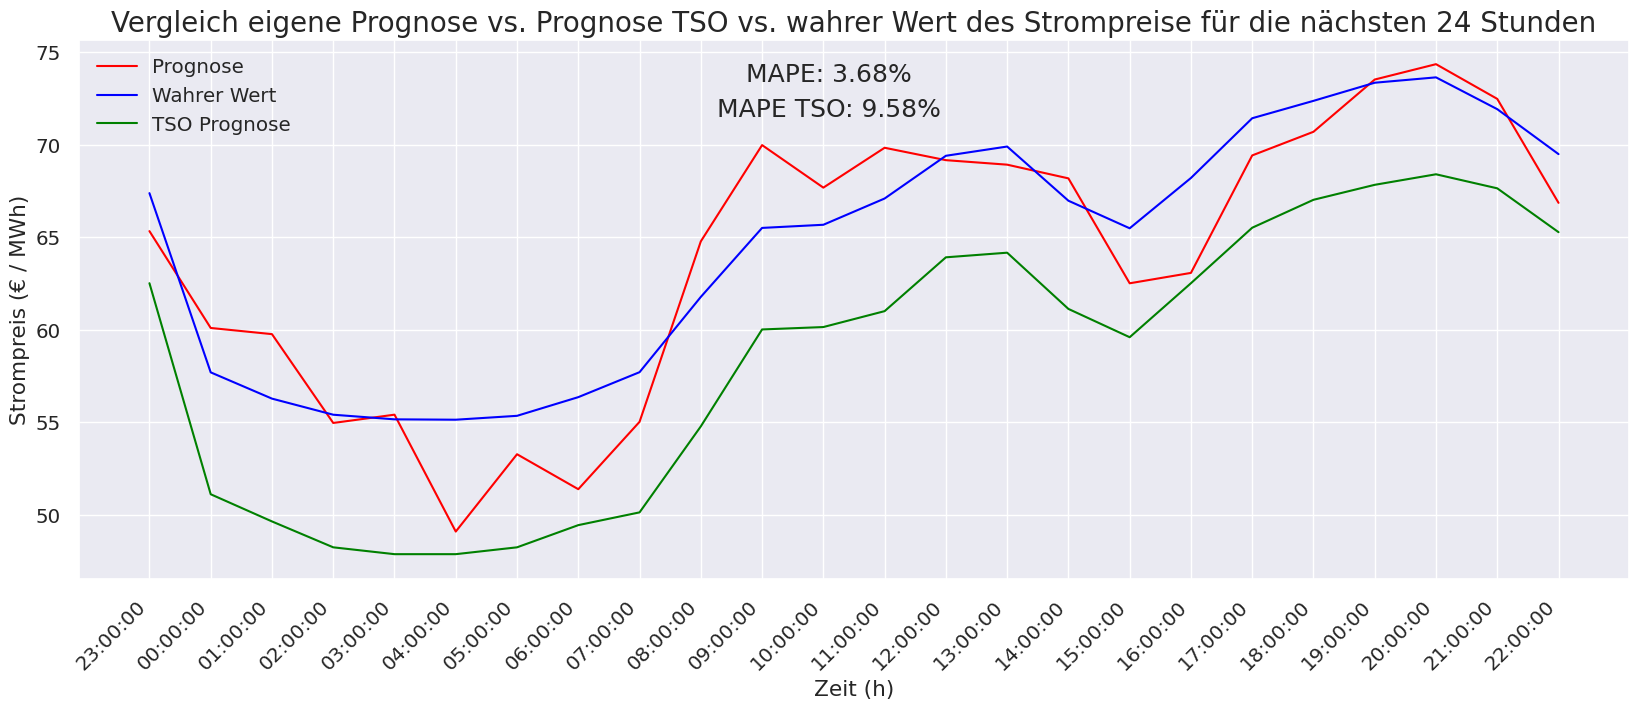

In [147]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
sns.set_style("darkgrid") 
sns.lineplot(x = a["time_new"], y = a["price_pred"], color="red", label="Prognose")
sns.lineplot(x = a["time_new"], y = a["price"], color="blue", label="Wahrer Wert")
sns.lineplot(x = a["time_new"], y = a["price_dayahead"], color="green", label="TSO Prognose")
plt.title("Vergleich eigene Prognose vs. Prognose TSO vs. wahrer Wert des Strompreise für die nächsten 24 Stunden", fontsize=20)
plt.xlabel("Zeit (h)")
plt.ylabel("Strompreis (€ / MWh)")
plt.figtext(.5, .82, "MAPE: " + str(round(mape_pred*100, 2)) + "%", fontsize=18, ha='center')
plt.figtext(.5, .77, "MAPE TSO: " + str(round(mape_pred_tso*100, 2)) + "%", fontsize=18, ha='center')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left')